# Day 4 - Exercise 6: LangGraph HR Policies RAG vs MCP Comparison

## Overview
This exercise demonstrates how to build LangGraph agents using both RAG (Retrieval-Augmented Generation) and MCP (Model Context Protocol) approaches for HR policy management across different countries (India, US, UK).

## Learning Objectives
1. Understand how to implement LangGraph workflows with multiple agents
2. Compare RAG vs MCP approaches for document-based queries
3. Build HR policy management system with country-specific policies
4. Implement performance metrics and cost analysis
5. Demonstrate agent orchestration and decision making

## Table of Contents
1. [Setup and Imports](#setup)
2. [HR Policies Data Setup](#data)
3. [RAG Agent Implementation](#rag)
4. [MCP Agent Implementation](#mcp)
5. [LangGraph Workflow](#workflow)
6. [Performance Comparison](#comparison)
7. [Testing and Evaluation](#testing)


## 🚀 QUICK START INSTRUCTIONS

### **STEP 1: Set Your API Key**
1. Go to [OpenAI API Keys](https://platform.openai.com/api-keys)
2. Create a new API key
3. Replace `"sk-your-openai-api-key-here"` in the next cell with your actual API key
4. Run all cells in order

### **STEP 2: Run the Analysis**
- Execute all cells sequentially
- The system will automatically install dependencies
- You'll get comprehensive RAG vs MCP analysis with:
  - Groundedness scores
  - F1 score analysis  
  - Clarity evaluation
  - Token usage tracking
  - Interactive visualizations

### **STEP 3: View Results**
- Interactive 9-panel dashboard
- Detailed comparison tables
- Performance improvement percentages
- Enterprise recommendations

---


## 1. Setup and Imports {#setup}


In [1]:
# Core imports
import os
import json
import asyncio
from typing import Dict, List, Any, Optional, TypedDict
from datetime import datetime
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# LangChain imports
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

# LangGraph imports
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver

# Vector store and embeddings
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

# LLM imports
from langchain_openai import ChatOpenAI

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Text analysis imports
import re
import nltk
from sklearn.metrics import f1_score, precision_score, recall_score
from collections import Counter

# Handle textstat import gracefully
try:
    from textstat import flesch_reading_ease, flesch_kincaid_grade
    TEXTSTAT_AVAILABLE = True
    print("✅ textstat imported successfully")
except ImportError:
    print("⚠️  textstat not available, using fallback functions")
    TEXTSTAT_AVAILABLE = False
    
    # Fallback functions for textstat
    def flesch_reading_ease(text):
        """Fallback Flesch Reading Ease calculation"""
        sentences = text.count('.') + text.count('!') + text.count('?')
        words = len(text.split())
        if sentences == 0 or words == 0:
            return 50  # Default middle score
        syllables = sum([len(word) for word in text.split()]) / 3  # Rough estimate
        return max(0, min(100, 206.835 - (1.015 * (words / sentences)) - (84.6 * (syllables / words))))
    
    def flesch_kincaid_grade(text):
        """Fallback Flesch-Kincaid Grade calculation"""
        sentences = text.count('.') + text.count('!') + text.count('?')
        words = len(text.split())
        if sentences == 0 or words == 0:
            return 8  # Default grade level
        syllables = sum([len(word) for word in text.split()]) / 3  # Rough estimate
        return max(0, (0.39 * (words / sentences)) + (11.8 * (syllables / words)) - 15.59)

# Download required NLTK data
try:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('averaged_perceptron_tagger', quiet=True)
except:
    pass

# Utilities
import time
import logging
from dataclasses import dataclass, field
from enum import Enum

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Set up matplotlib for better display
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("✅ All imports successful!")
print("✅ NLTK data downloaded!")
print("✅ Visualization libraries ready!")


✅ textstat imported successfully
✅ All imports successful!
✅ NLTK data downloaded!
✅ Visualization libraries ready!


In [2]:
# API Key Setup and Configuration
import os

# HARDCODED API KEY - Replace with your actual OpenAI API key
# Get your API key from: https://platform.openai.com/api-keys
# Example format: "sk-proj-abc123def456ghi789jkl012mno345pqr678stu901vwx234yz"
OPENAI_API_KEY = ""

# Set the API key
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY

print("🔑 API Key Configuration")
print("=" * 40)

# Check if key is set
if OPENAI_API_KEY and OPENAI_API_KEY != "sk-your-openai-api-key-here":
    print("✅ API key is set!")
    
    # Verify API key is working
    try:
        from langchain_openai import ChatOpenAI
        test_llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.1, max_tokens=10)
        test_response = test_llm.invoke("Hello")
        print("✅ API key is working correctly!")
        print("🚀 Ready to run the analysis!")
    except Exception as e:
        print(f"❌ API key test failed: {str(e)}")
        print("Please check your API key and try again.")
        print("\nTo fix this:")
        print("1. Replace 'sk-your-openai-api-key-here' with your actual API key")
        print("2. Get your API key from: https://platform.openai.com/api-keys")
        print("3. Make sure you have credits in your OpenAI account")
else:
    print("⚠️  Please set your OpenAI API key!")
    print("Replace 'sk-your-openai-api-key-here' with your actual API key")
    print("Get your API key from: https://platform.openai.com/api-keys")

print("=" * 40)


🔑 API Key Configuration
✅ API key is set!


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


✅ API key is working correctly!
🚀 Ready to run the analysis!


In [3]:
# Install missing dependencies if needed
import subprocess
import sys

def install_package(package):
    """Install a package if it's not already installed"""
    try:
        __import__(package)
        return True
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        return False

# Check and install required packages
required_packages = [
    "textstat",
    "scikit-learn", 
    "sentence-transformers",
    "faiss-cpu"
]

for package in required_packages:
    try:
        if package == "scikit-learn":
            import sklearn
        elif package == "faiss-cpu":
            import faiss
        elif package == "sentence-transformers":
            from sentence_transformers import SentenceTransformer
        elif package == "textstat":
            import textstat
        else:
            __import__(package)
        print(f"✅ {package} is already installed")
    except ImportError:
        print(f"📦 Installing {package}...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
            print(f"✅ {package} installed successfully")
        except Exception as e:
            print(f"❌ Failed to install {package}: {str(e)}")
            print(f"Please install manually: pip install {package}")
            if package == "textstat":
                print("ℹ️  textstat is optional - fallback functions will be used")

print("🔧 Dependency check complete!")


✅ textstat is already installed
✅ scikit-learn is already installed


INFO:faiss.loader:Loading faiss.
INFO:faiss.loader:Successfully loaded faiss.


✅ sentence-transformers is already installed
✅ faiss-cpu is already installed
🔧 Dependency check complete!


## 2. HR Policies Data Setup {#data}


In [4]:
# Load Actual HR Policy Files
def load_hr_policy_files():
    """Load actual HR policy files from the directory"""
    policy_files = {
        "India": "hr_policies_india.txt",
        "USA": "hr_policies_usa.txt", 
        "UK": "hr_policies_uk.txt"
    }
    
    loaded_policies = {}
    
    for country, filename in policy_files.items():
        try:
            file_path = filename
            with open(file_path, 'r', encoding='utf-8') as file:
                content = file.read()
                loaded_policies[country] = content
                print(f"✅ Loaded {filename} ({len(content)} characters)")
        except FileNotFoundError:
            print(f"❌ File {filename} not found")
        except Exception as e:
            print(f"❌ Error loading {filename}: {str(e)}")
    
    return loaded_policies

# Load the actual policy files
print("📁 Loading HR Policy Files...")
print("=" * 50)
actual_policy_files = load_hr_policy_files()

if actual_policy_files:
    print(f"\n✅ Successfully loaded {len(actual_policy_files)} policy files")
    print("Countries loaded:", list(actual_policy_files.keys()))
else:
    print("❌ No policy files loaded. Using fallback data.")
    actual_policy_files = None


📁 Loading HR Policy Files...
✅ Loaded hr_policies_india.txt (8339 characters)
✅ Loaded hr_policies_usa.txt (9493 characters)
✅ Loaded hr_policies_uk.txt (9749 characters)

✅ Successfully loaded 3 policy files
Countries loaded: ['India', 'USA', 'UK']


In [5]:
# Convert policies to text format for vector store
def create_policy_documents_from_files(policy_files: Dict) -> List[Dict[str, str]]:
    """Convert actual HR policy files to document format for vector store"""
    documents = []
    
    if not policy_files:
        print("⚠️  No policy files available, using fallback data")
        return create_policy_documents(HR_POLICIES)
    
    for country, content in policy_files.items():
        # Split the content into logical sections
        sections = content.split('## ')
        
        for i, section in enumerate(sections):
            if not section.strip():
                continue
                
            # Clean up the section
            section = section.strip()
            if section.startswith('#'):
                section = section[1:].strip()
            
            # Create document for each section
            documents.append({
                "content": section,
                "metadata": {
                    "country": country,
                    "section": f"section_{i}",
                    "source": "hr_policy_files",
                    "file_type": "txt"
                }
            })
    
    return documents

def create_policy_documents(policies: Dict) -> List[Dict[str, str]]:
    """Convert HR policies to document format for vector store"""
    documents = []
    
    for country, policy_categories in policies.items():
        for category, details in policy_categories.items():
            # Create a comprehensive document for each policy category
            content = f"""
Country: {country}
Policy Category: {category.replace('_', ' ').title()}

Details:
"""
            
            for key, value in details.items():
                content += f"{key.replace('_', ' ').title()}: {value}\n"
            
            documents.append({
                "content": content.strip(),
                "metadata": {
                    "country": country,
                    "category": category,
                    "source": "hr_policies"
                }
            })
    
    return documents

# Create policy documents from actual files or fallback
if actual_policy_files:
    print("\n📄 Creating documents from actual policy files...")
    policy_documents = create_policy_documents_from_files(actual_policy_files)
    print(f"✅ Created {len(policy_documents)} policy documents from files")
else:
    print("\n📄 Creating documents from fallback data...")
    policy_documents = create_policy_documents(HR_POLICIES)
    print(f"✅ Created {len(policy_documents)} policy documents from fallback")

print(f"Sample document: {policy_documents[0]['content'][:200]}...")



📄 Creating documents from actual policy files...
✅ Created 128 policy documents from files
Sample document: INDIA HR POLICIES - LEAVE MANAGEMENT
# Version: 2.1 | Last Updated: 2024-01-15
# Coverage: All India Operations

INDIA ...


## 3. RAG Agent Implementation {#rag}


In [6]:
# RAG Agent Implementation
class RAGAgent:
    def __init__(self, llm, vector_store, embeddings):
        self.llm = llm
        self.vector_store = vector_store
        self.embeddings = embeddings
        self.retrieval_chain = self._create_retrieval_chain()
    
    def _create_retrieval_chain(self):
        """Create the RAG retrieval chain"""
        retriever = self.vector_store.as_retriever(
            search_type="similarity",
            search_kwargs={"k": 3}
        )
        
        prompt = ChatPromptTemplate.from_template("""
You are an HR Policy Assistant. Use the following context to answer questions about HR policies.

Context:
{context}

Question: {question}

Please provide a comprehensive answer based on the context. If the information is not available in the context, please state that clearly.

Answer:
""")
        
        chain = (
            {"context": retriever, "question": RunnablePassthrough()}
            | prompt
            | self.llm
            | StrOutputParser()
        )
        
        return chain
    
    def query(self, question: str) -> Dict[str, Any]:
        """Query the RAG agent"""
        start_time = time.time()
        
        try:
            # Get relevant documents
            relevant_docs = self.vector_store.similarity_search(question, k=3)
            
            # Generate response
            response = self.retrieval_chain.invoke(question)
            
            end_time = time.time()
            
            return {
                "response": response,
                "relevant_docs": [doc.page_content for doc in relevant_docs],
                "response_time": end_time - start_time,
                "method": "RAG",
                "success": True
            }
        except Exception as e:
            return {
                "response": f"Error: {str(e)}",
                "relevant_docs": [],
                "response_time": time.time() - start_time,
                "method": "RAG",
                "success": False
            }

# Initialize RAG components
print("Setting up RAG components...")

# Initialize embeddings
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)

# Initialize LLM
llm = ChatOpenAI(
    model="gpt-3.5-turbo",
    temperature=0.1
)

# Create vector store
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200
)

# Split documents
split_docs = text_splitter.create_documents(
    [doc["content"] for doc in policy_documents],
    metadatas=[doc["metadata"] for doc in policy_documents]
)

# Create FAISS vector store
vector_store = FAISS.from_documents(split_docs, embeddings)

# Initialize RAG agent
rag_agent = RAGAgent(llm, vector_store, embeddings)

print("✅ RAG Agent initialized successfully!")


/var/folders/7s/jcp2dsss28lbqc7_f9j6vdb00000gn/T/ipykernel_88785/1157513746.py:71: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: mps
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


Setting up RAG components...
✅ RAG Agent initialized successfully!


## 4. MCP Agent Implementation {#mcp}


In [7]:
# MCP Agent Implementation
class MCPAgent:
    def __init__(self, llm, policies_data):
        self.llm = llm
        self.policies_data = policies_data
        self.tools = self._create_tools()
    
    def _create_tools(self):
        """Create MCP tools for HR policy queries"""
        def get_policy_by_country(country: str, category: str = None) -> str:
            """Get HR policy for a specific country and category"""
            if country not in self.policies_data:
                return f"Country '{country}' not found. Available countries: {list(self.policies_data.keys())}"
            
            if category:
                if category in self.policies_data[country]:
                    return json.dumps(self.policies_data[country][category], indent=2)
                else:
                    return f"Category '{category}' not found for {country}. Available categories: {list(self.policies_data[country].keys())}"
            
            return json.dumps(self.policies_data[country], indent=2)
        
        def search_policies(query: str) -> str:
            """Search for policies across all countries"""
            results = []
            query_lower = query.lower()
            
            for country, policies in self.policies_data.items():
                for category, details in policies.items():
                    for key, value in details.items():
                        if query_lower in key.lower() or query_lower in value.lower():
                            results.append({
                                "country": country,
                                "category": category,
                                "key": key,
                                "value": value
                            })
            
            return json.dumps(results, indent=2)
        
        def compare_policies(country1: str, country2: str, category: str) -> str:
            """Compare policies between two countries for a specific category"""
            if country1 not in self.policies_data or country2 not in self.policies_data:
                return "One or both countries not found."
            
            if category not in self.policies_data[country1] or category not in self.policies_data[country2]:
                return f"Category '{category}' not found in one or both countries."
            
            comparison = {
                "category": category,
                "countries": {
                    country1: self.policies_data[country1][category],
                    country2: self.policies_data[country2][category]
                }
            }
            
            return json.dumps(comparison, indent=2)
        
        return {
            "get_policy_by_country": get_policy_by_country,
            "search_policies": search_policies,
            "compare_policies": compare_policies
        }
    
    def query(self, question: str) -> Dict[str, Any]:
        """Query the MCP agent"""
        start_time = time.time()
        
        try:
            # Create a prompt that includes available tools
            tool_descriptions = "\n".join([
                f"- {name}: {func.__doc__}" 
                for name, func in self.tools.items()
            ])
            
            prompt = f"""
You are an HR Policy Assistant with access to the following tools:

{tool_descriptions}

Available countries: {list(self.policies_data.keys())}
Available categories: annual_leave, sick_leave, working_hours, holidays

Question: {question}

Please use the appropriate tools to answer this question. If you need to use multiple tools, do so in a logical sequence.

Answer:
"""
            
            # For this demo, we'll use a simple approach
            # In a real MCP implementation, you would use the MCP protocol
            response = self.llm.invoke(prompt).content
            
            end_time = time.time()
            
            return {
                "response": response,
                "tools_used": list(self.tools.keys()),
                "response_time": end_time - start_time,
                "method": "MCP",
                "success": True
            }
        except Exception as e:
            return {
                "response": f"Error: {str(e)}",
                "tools_used": [],
                "response_time": time.time() - start_time,
                "method": "MCP",
                "success": False
            }

# Initialize MCP agent with actual policy files or fallback
if actual_policy_files:
    print("🔧 Initializing MCP agent with actual policy files...")
    # Convert file content to structured format for MCP
    structured_policies = {}
    for country, content in actual_policy_files.items():
        # Extract key information from the content
        structured_policies[country] = {
            "annual_leave": "See policy file for detailed annual leave information",
            "sick_leave": "See policy file for detailed sick leave information", 
            "working_hours": "See policy file for detailed working hours information",
            "holidays": "See policy file for detailed holiday information",
            "raw_content": content  # Store full content for reference
        }
    mcp_agent = MCPAgent(llm, structured_policies)
    print("✅ MCP Agent initialized with actual policy files!")
else:
    print("🔧 Initializing MCP agent with fallback data...")
    mcp_agent = MCPAgent(llm, HR_POLICIES)
    print("✅ MCP Agent initialized with fallback data!")


🔧 Initializing MCP agent with actual policy files...
✅ MCP Agent initialized with actual policy files!


## 5. LangGraph Workflow and Evaluation System {#workflow}


In [8]:
# Advanced Evaluation Metrics and Performance Tracking
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass, field
from typing import List, Dict, Any
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

@dataclass
class PerformanceMetrics:
    """Track performance metrics for both RAG and MCP agents"""
    method: str
    query: str
    response_time: float
    token_count: int
    cost: float
    accuracy_score: float = 0.0
    relevance_score: float = 0.0
    completeness_score: float = 0.0
    response_quality: str = ""
    timestamp: datetime = field(default_factory=datetime.now)
    
    def to_dict(self):
        return {
            'method': self.method,
            'query': self.query,
            'response_time': self.response_time,
            'token_count': self.token_count,
            'cost': self.cost,
            'accuracy_score': self.accuracy_score,
            'relevance_score': self.relevance_score,
            'completeness_score': self.completeness_score,
            'response_quality': self.response_quality,
            'timestamp': self.timestamp
        }

class IntelligentEvaluator:
    """LLM-driven evaluation system for enterprise applications"""
    
    def __init__(self, llm):
        self.llm = llm
        self.evaluation_prompt = ChatPromptTemplate.from_template("""
You are an expert AI evaluator for enterprise applications. Evaluate the following response based on the given criteria.

Query: {query}
Response: {response}
Method: {method}

Please evaluate on a scale of 1-10 for each criterion:

1. ACCURACY: How factually correct and precise is the response?
2. RELEVANCE: How well does the response address the specific query?
3. COMPLETENESS: How comprehensive and thorough is the response?
4. CLARITY: How clear and understandable is the response?
5. ACTIONABILITY: How actionable and practical is the response for HR professionals?

Provide your evaluation in the following JSON format:
{{
    "accuracy_score": <score>,
    "relevance_score": <score>,
    "completeness_score": <score>,
    "clarity_score": <score>,
    "actionability_score": <score>,
    "overall_quality": "<excellent/good/fair/poor>",
    "strengths": ["strength1", "strength2"],
    "weaknesses": ["weakness1", "weakness2"],
    "recommendations": ["recommendation1", "recommendation2"]
}}

Be critical but fair in your evaluation. Consider enterprise use cases and professional standards.
""")
    
    def evaluate_response(self, query: str, response: str, method: str) -> Dict[str, Any]:
        """Evaluate a response using LLM-based assessment"""
        try:
            evaluation_chain = self.evaluation_prompt | self.llm | StrOutputParser()
            evaluation_result = evaluation_chain.invoke({
                "query": query,
                "response": response,
                "method": method
            })
            
            # Parse JSON response
            import json
            try:
                evaluation_data = json.loads(evaluation_result)
                return evaluation_data
            except json.JSONDecodeError:
                # Fallback if JSON parsing fails
                return {
                    "accuracy_score": 5.0,
                    "relevance_score": 5.0,
                    "completeness_score": 5.0,
                    "clarity_score": 5.0,
                    "actionability_score": 5.0,
                    "overall_quality": "fair",
                    "strengths": [],
                    "weaknesses": ["JSON parsing failed"],
                    "recommendations": ["Improve response format"]
                }
        except Exception as e:
            return {
                "accuracy_score": 0.0,
                "relevance_score": 0.0,
                "completeness_score": 0.0,
                "clarity_score": 0.0,
                "actionability_score": 0.0,
                "overall_quality": "poor",
                "strengths": [],
                "weaknesses": [f"Evaluation error: {str(e)}"],
                "recommendations": ["Fix evaluation system"]
            }

class TokenTracker:
    """Track token usage and costs for both methods"""
    
    def __init__(self):
        self.token_costs = {
            "gpt-3.5-turbo": {"input": 0.0015, "output": 0.002},  # per 1K tokens
            "gpt-4": {"input": 0.03, "output": 0.06},
            "gpt-4-turbo": {"input": 0.01, "output": 0.03}
        }
    
    def estimate_tokens(self, text: str) -> int:
        """Estimate token count (rough approximation)"""
        return len(text.split()) * 1.3  # Rough estimation
    
    def calculate_cost(self, input_tokens: int, output_tokens: int, model: str = "gpt-3.5-turbo") -> float:
        """Calculate cost based on token usage"""
        if model not in self.token_costs:
            model = "gpt-3.5-turbo"
        
        input_cost = (input_tokens / 1000) * self.token_costs[model]["input"]
        output_cost = (output_tokens / 1000) * self.token_costs[model]["output"]
        
        return input_cost + output_cost

# Initialize evaluation components
evaluator = IntelligentEvaluator(llm)
token_tracker = TokenTracker()
performance_data = []

print("✅ Advanced evaluation system initialized!")


✅ Advanced evaluation system initialized!


In [9]:
# LangGraph Workflow for Agent Orchestration
class AgentState(TypedDict):
    query: str
    rag_response: Optional[Dict[str, Any]]
    mcp_response: Optional[Dict[str, Any]]
    evaluation_results: Optional[Dict[str, Any]]
    final_recommendation: Optional[str]
    performance_metrics: List[PerformanceMetrics]

def rag_node(state: AgentState) -> AgentState:
    """RAG agent node"""
    query = state["query"]
    print(f"🔍 RAG Agent processing: {query}")
    
    rag_result = rag_agent.query(query)
    state["rag_response"] = rag_result
    
    # Track performance metrics
    input_tokens = token_tracker.estimate_tokens(query)
    output_tokens = token_tracker.estimate_tokens(rag_result["response"])
    cost = token_tracker.calculate_cost(input_tokens, output_tokens)
    
    metrics = PerformanceMetrics(
        method="RAG",
        query=query,
        response_time=rag_result["response_time"],
        token_count=input_tokens + output_tokens,
        cost=cost
    )
    
    state["performance_metrics"].append(metrics)
    return state

def mcp_node(state: AgentState) -> AgentState:
    """MCP agent node"""
    query = state["query"]
    print(f"🔧 MCP Agent processing: {query}")
    
    mcp_result = mcp_agent.query(query)
    state["mcp_response"] = mcp_result
    
    # Track performance metrics
    input_tokens = token_tracker.estimate_tokens(query)
    output_tokens = token_tracker.estimate_tokens(mcp_result["response"])
    cost = token_tracker.calculate_cost(input_tokens, output_tokens)
    
    metrics = PerformanceMetrics(
        method="MCP",
        query=query,
        response_time=mcp_result["response_time"],
        token_count=input_tokens + output_tokens,
        cost=cost
    )
    
    state["performance_metrics"].append(metrics)
    return state

def evaluation_node(state: AgentState) -> AgentState:
    """Evaluation node using LLM-driven assessment"""
    query = state["query"]
    rag_response = state["rag_response"]["response"]
    mcp_response = state["mcp_response"]["response"]
    
    print("📊 Evaluating responses...")
    
    # Evaluate both responses
    rag_evaluation = evaluator.evaluate_response(query, rag_response, "RAG")
    mcp_evaluation = evaluator.evaluate_response(query, mcp_response, "MCP")
    
    # Update performance metrics with evaluation scores
    for metrics in state["performance_metrics"]:
        if metrics.method == "RAG":
            metrics.accuracy_score = rag_evaluation["accuracy_score"]
            metrics.relevance_score = rag_evaluation["relevance_score"]
            metrics.completeness_score = rag_evaluation["completeness_score"]
            metrics.response_quality = rag_evaluation["overall_quality"]
        elif metrics.method == "MCP":
            metrics.accuracy_score = mcp_evaluation["accuracy_score"]
            metrics.relevance_score = mcp_evaluation["relevance_score"]
            metrics.completeness_score = mcp_evaluation["completeness_score"]
            metrics.response_quality = mcp_evaluation["overall_quality"]
    
    state["evaluation_results"] = {
        "rag_evaluation": rag_evaluation,
        "mcp_evaluation": mcp_evaluation
    }
    
    return state

def recommendation_node(state: AgentState) -> AgentState:
    """Generate final recommendation based on evaluation"""
    evaluation_results = state["evaluation_results"]
    rag_eval = evaluation_results["rag_evaluation"]
    mcp_eval = evaluation_results["mcp_evaluation"]
    
    # Calculate overall scores
    rag_score = (rag_eval["accuracy_score"] + rag_eval["relevance_score"] + 
                rag_eval["completeness_score"]) / 3
    mcp_score = (mcp_eval["accuracy_score"] + mcp_eval["relevance_score"] + 
                mcp_eval["completeness_score"]) / 3
    
    # Generate intelligent recommendation
    recommendation_prompt = f"""
Based on the following evaluation results, provide a comprehensive recommendation for enterprise use:

RAG Performance:
- Accuracy: {rag_eval['accuracy_score']}/10
- Relevance: {rag_eval['relevance_score']}/10
- Completeness: {rag_eval['completeness_score']}/10
- Overall Quality: {rag_eval['overall_quality']}
- Strengths: {rag_eval['strengths']}
- Weaknesses: {rag_eval['weaknesses']}

MCP Performance:
- Accuracy: {mcp_eval['accuracy_score']}/10
- Relevance: {mcp_eval['relevance_score']}/10
- Completeness: {mcp_eval['completeness_score']}/10
- Overall Quality: {mcp_eval['overall_quality']}
- Strengths: {mcp_eval['strengths']}
- Weaknesses: {mcp_eval['weaknesses']}

Provide a detailed recommendation including:
1. Which method performs better for this specific query
2. Key advantages and disadvantages of each approach
3. Enterprise implementation considerations
4. Cost-benefit analysis
5. Specific recommendations for improvement

Be objective and provide actionable insights for enterprise decision-making.
"""
    
    recommendation = llm.invoke(recommendation_prompt).content
    state["final_recommendation"] = recommendation
    
    return state

# Create LangGraph workflow
def create_agent_workflow():
    """Create the LangGraph workflow"""
    workflow = StateGraph(AgentState)
    
    # Add nodes
    workflow.add_node("rag_agent", rag_node)
    workflow.add_node("mcp_agent", mcp_node)
    workflow.add_node("evaluator", evaluation_node)
    workflow.add_node("recommender", recommendation_node)
    
    # Define the flow
    workflow.set_entry_point("rag_agent")
    workflow.add_edge("rag_agent", "mcp_agent")
    workflow.add_edge("mcp_agent", "evaluator")
    workflow.add_edge("evaluator", "recommender")
    workflow.add_edge("recommender", END)
    
    return workflow.compile()

# Initialize workflow
agent_workflow = create_agent_workflow()
print("✅ LangGraph workflow created successfully!")


✅ LangGraph workflow created successfully!


## 6. Performance Analysis and Visualization {#comparison}


In [10]:
# Comprehensive Performance Analysis and Visualization
class PerformanceAnalyzer:
    """Advanced performance analysis with intelligent insights"""
    
    def __init__(self, performance_data: List[PerformanceMetrics]):
        self.performance_data = performance_data
        self.df = pd.DataFrame([metric.to_dict() for metric in performance_data])
    
    def generate_performance_summary(self) -> Dict[str, Any]:
        """Generate comprehensive performance summary"""
        if self.df.empty:
            return {"error": "No performance data available"}
        
        summary = {}
        
        # Group by method
        for method in self.df['method'].unique():
            method_data = self.df[self.df['method'] == method]
            
            summary[method] = {
                "avg_response_time": method_data['response_time'].mean(),
                "avg_token_count": method_data['token_count'].mean(),
                "avg_cost": method_data['cost'].mean(),
                "avg_accuracy": method_data['accuracy_score'].mean(),
                "avg_relevance": method_data['relevance_score'].mean(),
                "avg_completeness": method_data['completeness_score'].mean(),
                "total_queries": len(method_data),
                "success_rate": (method_data['accuracy_score'] > 5).mean() * 100
            }
        
        return summary
    
    def create_performance_visualizations(self):
        """Create comprehensive performance visualizations"""
        if self.df.empty:
            print("No data available for visualization")
            return
        
        # Set up the plotting style
        plt.style.use('seaborn-v0_8')
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('RAG vs MCP Performance Analysis', fontsize=16, fontweight='bold')
        
        # 1. Response Time Comparison
        sns.boxplot(data=self.df, x='method', y='response_time', ax=axes[0, 0])
        axes[0, 0].set_title('Response Time Comparison')
        axes[0, 0].set_ylabel('Response Time (seconds)')
        
        # 2. Token Usage Comparison
        sns.boxplot(data=self.df, x='method', y='token_count', ax=axes[0, 1])
        axes[0, 1].set_title('Token Usage Comparison')
        axes[0, 1].set_ylabel('Token Count')
        
        # 3. Cost Comparison
        sns.boxplot(data=self.df, x='method', y='cost', ax=axes[0, 2])
        axes[0, 2].set_title('Cost Comparison')
        axes[0, 2].set_ylabel('Cost ($)')
        
        # 4. Accuracy Scores
        accuracy_data = self.df[['method', 'accuracy_score', 'relevance_score', 'completeness_score']].melt(
            id_vars=['method'], 
            var_name='metric', 
            value_name='score'
        )
        sns.boxplot(data=accuracy_data, x='method', y='score', hue='metric', ax=axes[1, 0])
        axes[1, 0].set_title('Quality Metrics Comparison')
        axes[1, 0].set_ylabel('Score (1-10)')
        axes[1, 0].legend(title='Metric')
        
        # 5. Performance Trend Over Time
        if 'timestamp' in self.df.columns:
            time_data = self.df.copy()
            time_data['time_index'] = range(len(time_data))
            sns.lineplot(data=time_data, x='time_index', y='response_time', hue='method', ax=axes[1, 1])
            axes[1, 1].set_title('Performance Trend Over Time')
            axes[1, 1].set_ylabel('Response Time (seconds)')
        
        # 6. Cost vs Performance Scatter
        sns.scatterplot(data=self.df, x='cost', y='accuracy_score', hue='method', size='token_count', ax=axes[1, 2])
        axes[1, 2].set_title('Cost vs Performance')
        axes[1, 2].set_xlabel('Cost ($)')
        axes[1, 2].set_ylabel('Accuracy Score')
        
        plt.tight_layout()
        plt.show()
    
    def create_interactive_dashboard(self):
        """Create interactive Plotly dashboard"""
        if self.df.empty:
            print("No data available for dashboard")
            return
        
        # Create subplots
        fig = make_subplots(
            rows=2, cols=3,
            subplot_titles=('Response Time', 'Token Usage', 'Cost Analysis', 
                          'Quality Scores', 'Performance Trend', 'Efficiency Matrix'),
            specs=[[{"type": "box"}, {"type": "box"}, {"type": "box"}],
                   [{"type": "bar"}, {"type": "scatter"}, {"type": "scatter"}]]
        )
        
        # Response Time
        for method in self.df['method'].unique():
            method_data = self.df[self.df['method'] == method]
            fig.add_trace(
                go.Box(y=method_data['response_time'], name=f"{method} Response Time"),
                row=1, col=1
            )
        
        # Token Usage
        for method in self.df['method'].unique():
            method_data = self.df[self.df['method'] == method]
            fig.add_trace(
                go.Box(y=method_data['token_count'], name=f"{method} Tokens"),
                row=1, col=2
            )
        
        # Cost Analysis
        for method in self.df['method'].unique():
            method_data = self.df[self.df['method'] == method]
            fig.add_trace(
                go.Box(y=method_data['cost'], name=f"{method} Cost"),
                row=1, col=3
            )
        
        # Quality Scores
        quality_metrics = ['accuracy_score', 'relevance_score', 'completeness_score']
        for method in self.df['method'].unique():
            method_data = self.df[self.df['method'] == method]
            avg_scores = [method_data[metric].mean() for metric in quality_metrics]
            fig.add_trace(
                go.Bar(x=quality_metrics, y=avg_scores, name=f"{method} Quality"),
                row=2, col=1
            )
        
        # Performance Trend
        if 'timestamp' in self.df.columns:
            for method in self.df['method'].unique():
                method_data = self.df[self.df['method'] == method].sort_values('timestamp')
                fig.add_trace(
                    go.Scatter(x=method_data.index, y=method_data['response_time'], 
                             mode='lines+markers', name=f"{method} Trend"),
                    row=2, col=2
                )
        
        # Efficiency Matrix (Cost vs Performance)
        for method in self.df['method'].unique():
            method_data = self.df[self.df['method'] == method]
            fig.add_trace(
                go.Scatter(x=method_data['cost'], y=method_data['accuracy_score'],
                          mode='markers', name=f"{method} Efficiency",
                          text=method_data['query'], hovertemplate='Cost: $%{x}<br>Accuracy: %{y}<br>Query: %{text}'),
                row=2, col=3
            )
        
        fig.update_layout(height=800, title_text="RAG vs MCP Performance Dashboard", showlegend=True)
        fig.show()
    
    def generate_enterprise_report(self) -> str:
        """Generate comprehensive enterprise report using LLM"""
        summary = self.generate_performance_summary()
        
        report_prompt = f"""
As an enterprise AI consultant, analyze the following performance data and provide a comprehensive report:

Performance Summary:
{json.dumps(summary, indent=2)}

Please provide a detailed enterprise report including:

1. EXECUTIVE SUMMARY
   - Key findings and recommendations
   - Overall performance comparison
   - Business impact assessment

2. DETAILED ANALYSIS
   - Performance metrics breakdown
   - Cost-benefit analysis
   - Scalability considerations
   - Enterprise readiness assessment

3. RECOMMENDATIONS
   - Which approach to use for different use cases
   - Implementation strategy
   - Risk mitigation strategies
   - ROI projections

4. NEXT STEPS
   - Immediate actions required
   - Long-term strategic considerations
   - Monitoring and optimization recommendations

Format the report professionally for enterprise stakeholders.
"""
        
        report = llm.invoke(report_prompt).content
        return report

# Initialize analyzer
analyzer = PerformanceAnalyzer(performance_data)
print("✅ Performance analyzer initialized!")


✅ Performance analyzer initialized!


## 7. Testing and Evaluation {#testing}


In [11]:
# Comprehensive Testing Suite
class EnterpriseTestSuite:
    """Enterprise-grade testing suite for RAG vs MCP comparison"""
    
    def __init__(self, workflow, analyzer):
        self.workflow = workflow
        self.analyzer = analyzer
        self.test_queries = [
            "What is the annual leave policy for India?",
            "How many sick days are employees entitled to in the USA?",
            "Compare maternity leave policies between UK and India",
            "What are the working hours for employees in the UK?",
            "How much notice is required for taking annual leave in the USA?",
            "What are the national holidays in India?",
            "Compare overtime pay policies across all three countries",
            "What medical certificate requirements exist for sick leave?",
            "How many bank holidays are there in the UK?",
            "What is the carry forward policy for annual leave in India?"
        ]
    
    def run_comprehensive_test(self):
        """Run comprehensive test suite"""
        print("🚀 Starting Enterprise Test Suite...")
        print("=" * 60)
        
        all_results = []
        
        for i, query in enumerate(self.test_queries, 1):
            print(f"\n📋 Test {i}/{len(self.test_queries)}: {query}")
            print("-" * 50)
            
            # Run workflow
            initial_state = {
                "query": query,
                "rag_response": None,
                "mcp_response": None,
                "evaluation_results": None,
                "final_recommendation": None,
                "performance_metrics": []
            }
            
            try:
                result = self.workflow.invoke(initial_state)
                all_results.append(result)
                
                # Display results
                self._display_test_results(result, i)
                
            except Exception as e:
                print(f"❌ Test {i} failed: {str(e)}")
                continue
        
        # Update analyzer with all results
        all_metrics = []
        for result in all_results:
            all_metrics.extend(result.get("performance_metrics", []))
        
        self.analyzer.performance_data = all_metrics
        self.analyzer.df = pd.DataFrame([metric.to_dict() for metric in all_metrics])
        
        return all_results
    
    def _display_test_results(self, result, test_num):
        """Display test results in a formatted way"""
        print(f"\n🔍 RAG Response:")
        print(f"   Time: {result['rag_response']['response_time']:.2f}s")
        print(f"   Success: {result['rag_response']['success']}")
        print(f"   Response: {result['rag_response']['response'][:100]}...")
        
        print(f"\n🔧 MCP Response:")
        print(f"   Time: {result['mcp_response']['response_time']:.2f}s")
        print(f"   Success: {result['mcp_response']['success']}")
        print(f"   Response: {result['mcp_response']['response'][:100]}...")
        
        if result.get('evaluation_results'):
            rag_eval = result['evaluation_results']['rag_evaluation']
            mcp_eval = result['evaluation_results']['mcp_evaluation']
            
            print(f"\n📊 Evaluation Scores:")
            print(f"   RAG  - Accuracy: {rag_eval['accuracy_score']}/10, Relevance: {rag_eval['relevance_score']}/10")
            print(f"   MCP  - Accuracy: {mcp_eval['accuracy_score']}/10, Relevance: {mcp_eval['relevance_score']}/10")
            
            print(f"\n💡 Recommendation:")
            print(f"   {result.get('final_recommendation', 'No recommendation available')[:200]}...")
    
    def generate_comparison_table(self):
        """Generate detailed comparison table"""
        if self.analyzer.df.empty:
            print("No data available for comparison table")
            return
        
        print("\n📊 DETAILED PERFORMANCE COMPARISON TABLE")
        print("=" * 80)
        
        # Create summary table
        summary_data = []
        for method in self.analyzer.df['method'].unique():
            method_data = self.analyzer.df[self.analyzer.df['method'] == method]
            
            summary_data.append({
                'Method': method,
                'Avg Response Time (s)': f"{method_data['response_time'].mean():.3f}",
                'Avg Token Count': f"{method_data['token_count'].mean():.0f}",
                'Avg Cost ($)': f"{method_data['cost'].mean():.4f}",
                'Avg Accuracy': f"{method_data['accuracy_score'].mean():.1f}/10",
                'Avg Relevance': f"{method_data['relevance_score'].mean():.1f}/10",
                'Avg Completeness': f"{method_data['completeness_score'].mean():.1f}/10",
                'Success Rate (%)': f"{(method_data['accuracy_score'] > 5).mean() * 100:.1f}",
                'Total Queries': len(method_data)
            })
        
        summary_df = pd.DataFrame(summary_data)
        print(summary_df.to_string(index=False))
        
        # Calculate improvements
        if len(summary_data) == 2:
            print(f"\n📈 PERFORMANCE IMPROVEMENTS")
            print("=" * 40)
            
            rag_data = method_data if method_data['method'].iloc[0] == 'RAG' else self.analyzer.df[self.analyzer.df['method'] == 'RAG']
            mcp_data = method_data if method_data['method'].iloc[0] == 'MCP' else self.analyzer.df[self.analyzer.df['method'] == 'MCP']
            
            improvements = {
                'Response Time': ((rag_data['response_time'].mean() - mcp_data['response_time'].mean()) / rag_data['response_time'].mean()) * 100,
                'Token Usage': ((rag_data['token_count'].mean() - mcp_data['token_count'].mean()) / rag_data['token_count'].mean()) * 100,
                'Cost': ((rag_data['cost'].mean() - mcp_data['cost'].mean()) / rag_data['cost'].mean()) * 100,
                'Accuracy': ((mcp_data['accuracy_score'].mean() - rag_data['accuracy_score'].mean()) / rag_data['accuracy_score'].mean()) * 100,
                'Relevance': ((mcp_data['relevance_score'].mean() - rag_data['relevance_score'].mean()) / rag_data['relevance_score'].mean()) * 100,
                'Completeness': ((mcp_data['completeness_score'].mean() - rag_data['completeness_score'].mean()) / rag_data['completeness_score'].mean()) * 100
            }
            
            for metric, improvement in improvements.items():
                direction = "better" if improvement > 0 else "worse"
                print(f"   {metric}: {improvement:+.1f}% ({direction})")
    
    def run_enterprise_analysis(self):
        """Run complete enterprise analysis"""
        print("🏢 ENTERPRISE ANALYSIS REPORT")
        print("=" * 50)
        
        # Run tests
        results = self.run_comprehensive_test()
        
        # Generate comparison table
        self.generate_comparison_table()
        
        # Create visualizations
        print("\n📊 Generating Performance Visualizations...")
        self.analyzer.create_performance_visualizations()
        
        # Generate enterprise report
        print("\n📋 Generating Enterprise Report...")
        enterprise_report = self.analyzer.generate_enterprise_report()
        
        print("\n" + "="*80)
        print("ENTERPRISE REPORT")
        print("="*80)
        print(enterprise_report)
        
        return results

# Initialize and run test suite
test_suite = EnterpriseTestSuite(agent_workflow, analyzer)
print("✅ Enterprise test suite initialized!")


✅ Enterprise test suite initialized!


## 8. Execute Enterprise Analysis {#execute}


🚀 Starting Enterprise RAG vs MCP Analysis...
This will run comprehensive tests and generate detailed performance metrics.
🏢 ENTERPRISE ANALYSIS REPORT
🚀 Starting Enterprise Test Suite...

📋 Test 1/10: What is the annual leave policy for India?
--------------------------------------------------
🔍 RAG Agent processing: What is the annual leave policy for India?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


🔧 MCP Agent processing: What is the annual leave policy for India?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


📊 Evaluating responses...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔍 RAG Response:
   Time: 2.63s
   Success: True
   Response: The annual leave policy for India is outlined in the document with the ID '47d464a5-65d9-493e-ace8-a...

🔧 MCP Response:
   Time: 1.28s
   Success: True
   Response: To find the annual leave policy for India, I will use the get_policy_by_country tool with the countr...

📊 Evaluation Scores:
   RAG  - Accuracy: 8/10, Relevance: 9/10
   MCP  - Accuracy: 9/10, Relevance: 10/10

💡 Recommendation:
   1. Based on the evaluation results, the MCP (Machine Learning-based Content Processing) method performs better for this specific query. It scored higher in accuracy, relevance, and completeness compar...

📋 Test 2/10: How many sick days are employees entitled to in the USA?
--------------------------------------------------
🔍 RAG Agent processing: How many sick days are employees entitled to in the USA?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


🔧 MCP Agent processing: How many sick days are employees entitled to in the USA?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


📊 Evaluating responses...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔍 RAG Response:
   Time: 3.28s
   Success: True
   Response: In the USA, all employees are entitled to 10 working days of sick leave per calendar year. This info...

🔧 MCP Response:
   Time: 1.79s
   Success: True
   Response: To find out how many sick days employees are entitled to in the USA, I will first use the get_policy...

📊 Evaluation Scores:
   RAG  - Accuracy: 9/10, Relevance: 10/10
   MCP  - Accuracy: 9/10, Relevance: 10/10

💡 Recommendation:
   1. Based on the evaluation results, the RAG method performs slightly better for this specific query as it scored higher in completeness compared to the MCP method.

2. Key advantages of the RAG method...

📋 Test 3/10: Compare maternity leave policies between UK and India
--------------------------------------------------
🔍 RAG Agent processing: Compare maternity leave policies between UK and India


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


🔧 MCP Agent processing: Compare maternity leave policies between UK and India


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


📊 Evaluating responses...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔍 RAG Response:
   Time: 2.18s
   Success: True
   Response: Based on the provided context, we have information on the maternity leave policies for both the UK a...

🔧 MCP Response:
   Time: 1.15s
   Success: True
   Response: To compare maternity leave policies between UK and India, I will use the compare_policies tool with ...

📊 Evaluation Scores:
   RAG  - Accuracy: 9/10, Relevance: 8/10
   MCP  - Accuracy: 9/10, Relevance: 10/10

💡 Recommendation:
   1. Based on the evaluation results, the MCP (compare_policies tool) performs better for this specific query as it scored higher in all aspects compared to RAG. MCP had higher scores in accuracy, relev...

📋 Test 4/10: What are the working hours for employees in the UK?
--------------------------------------------------
🔍 RAG Agent processing: What are the working hours for employees in the UK?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


🔧 MCP Agent processing: What are the working hours for employees in the UK?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


📊 Evaluating responses...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔍 RAG Response:
   Time: 1.43s
   Success: True
   Response: The working hours for employees in the UK are governed by the Working Time Regulations as outlined i...

🔧 MCP Response:
   Time: 1.13s
   Success: True
   Response: To find the working hours for employees in the UK, I will use the get_policy_by_country tool with th...

📊 Evaluation Scores:
   RAG  - Accuracy: 9/10, Relevance: 10/10
   MCP  - Accuracy: 9/10, Relevance: 10/10

💡 Recommendation:
   1. Based on the evaluation results, the RAG method performs slightly better for this specific query as it scored higher in completeness and accuracy compared to the MCP method.

2. Key advantages of t...

📋 Test 5/10: How much notice is required for taking annual leave in the USA?
--------------------------------------------------
🔍 RAG Agent processing: How much notice is required for taking annual leave in the USA?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


🔧 MCP Agent processing: How much notice is required for taking annual leave in the USA?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


📊 Evaluating responses...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔍 RAG Response:
   Time: 1.10s
   Success: True
   Response: In the context provided, the information regarding the notice required for taking annual leave in th...

🔧 MCP Response:
   Time: 1.49s
   Success: True
   Response: To find out how much notice is required for taking annual leave in the USA, I will first use the get...

📊 Evaluation Scores:
   RAG  - Accuracy: 8/10, Relevance: 7/10
   MCP  - Accuracy: 9/10, Relevance: 10/10

💡 Recommendation:
   Based on the evaluation results, the MCP method performs better for this specific query compared to the RAG method. The MCP method scored higher in accuracy, relevance, and completeness, resulting in ...

📋 Test 6/10: What are the national holidays in India?
--------------------------------------------------
🔍 RAG Agent processing: What are the national holidays in India?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


🔧 MCP Agent processing: What are the national holidays in India?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


📊 Evaluating responses...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔍 RAG Response:
   Time: 1.05s
   Success: True
   Response: The national holidays in India are not explicitly mentioned in the provided context. The documents p...

🔧 MCP Response:
   Time: 1.44s
   Success: True
   Response: To find the national holidays in India, I will first use the search_policies tool to search for the ...

📊 Evaluation Scores:
   RAG  - Accuracy: 8/10, Relevance: 7/10
   MCP  - Accuracy: 8/10, Relevance: 9/10

💡 Recommendation:
   1. In this specific query, the MCP (Machine Learning-based Content Processing) method performs better overall. It has higher scores in relevance and completeness compared to the RAG (Rule-based Answer...

📋 Test 7/10: Compare overtime pay policies across all three countries
--------------------------------------------------
🔍 RAG Agent processing: Compare overtime pay policies across all three countries


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


🔧 MCP Agent processing: Compare overtime pay policies across all three countries


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


📊 Evaluating responses...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔍 RAG Response:
   Time: 1.46s
   Success: True
   Response: The context provided only includes information about vacation accrual systems, sick leave entitlemen...

🔧 MCP Response:
   Time: 1.37s
   Success: True
   Response: To compare overtime pay policies across all three countries (India, USA, UK), we can use the compare...

📊 Evaluation Scores:
   RAG  - Accuracy: 8/10, Relevance: 6/10
   MCP  - Accuracy: 9/10, Relevance: 9/10

💡 Recommendation:
   1. Based on the evaluation results, the MCP (Method Comparison Process) performs better for this specific query compared to RAG (Red, Amber, Green) Performance. MCP scored higher in accuracy, relevanc...

📋 Test 8/10: What medical certificate requirements exist for sick leave?
--------------------------------------------------
🔍 RAG Agent processing: What medical certificate requirements exist for sick leave?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


🔧 MCP Agent processing: What medical certificate requirements exist for sick leave?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


📊 Evaluating responses...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔍 RAG Response:
   Time: 2.24s
   Success: True
   Response: In the context provided, the medical certificate requirements for sick leave vary depending on the c...

🔧 MCP Response:
   Time: 1.46s
   Success: True
   Response: To find out the medical certificate requirements for sick leave in each country, we can use the get_...

📊 Evaluation Scores:
   RAG  - Accuracy: 9/10, Relevance: 10/10
   MCP  - Accuracy: 9/10, Relevance: 10/10

💡 Recommendation:
   1. Based on the evaluation results, the RAG method performs better for this specific query as it received higher scores in accuracy, completeness, and overall quality compared to the MCP method.

2. K...

📋 Test 9/10: How many bank holidays are there in the UK?
--------------------------------------------------
🔍 RAG Agent processing: How many bank holidays are there in the UK?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


🔧 MCP Agent processing: How many bank holidays are there in the UK?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


📊 Evaluating responses...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔍 RAG Response:
   Time: 1.94s
   Success: True
   Response: In the UK, there are a total of 8 bank holidays in England & Wales, 9 bank holidays in Scotland, and...

🔧 MCP Response:
   Time: 1.04s
   Success: True
   Response: To find out how many bank holidays there are in the UK, I will use the `get_policy_by_country` tool ...

📊 Evaluation Scores:
   RAG  - Accuracy: 9/10, Relevance: 9/10
   MCP  - Accuracy: 9/10, Relevance: 10/10

💡 Recommendation:
   1. Based on the evaluation results, the MCP (Manual Content Processing) method performs better for this specific query. It scored higher in relevance and accuracy compared to the RAG (Rule-based Autom...

📋 Test 10/10: What is the carry forward policy for annual leave in India?
--------------------------------------------------
🔍 RAG Agent processing: What is the carry forward policy for annual leave in India?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


🔧 MCP Agent processing: What is the carry forward policy for annual leave in India?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


📊 Evaluating responses...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔍 RAG Response:
   Time: 2.61s
   Success: True
   Response: The carry forward policy for annual leave in India is not explicitly mentioned in the provided conte...

🔧 MCP Response:
   Time: 1.57s
   Success: True
   Response: To find the carry forward policy for annual leave in India, I will first use the get_policy_by_count...

📊 Evaluation Scores:
   RAG  - Accuracy: 8/10, Relevance: 7/10
   MCP  - Accuracy: 8/10, Relevance: 9/10

💡 Recommendation:
   1. Based on the evaluation results, the MCP method performs better for this specific query. It scored higher in relevance and completeness compared to RAG. 

2. Key advantages and disadvantages of eac...

📊 DETAILED PERFORMANCE COMPARISON TABLE
Method Avg Response Time (s) Avg Token Count Avg Cost ($) Avg Accuracy Avg Relevance Avg Completeness Success Rate (%)  Total Queries
   RAG                 1.992             152       0.0003       8.5/10        8.3/10           7.0/10            100.0             10
   MCP                 1.37

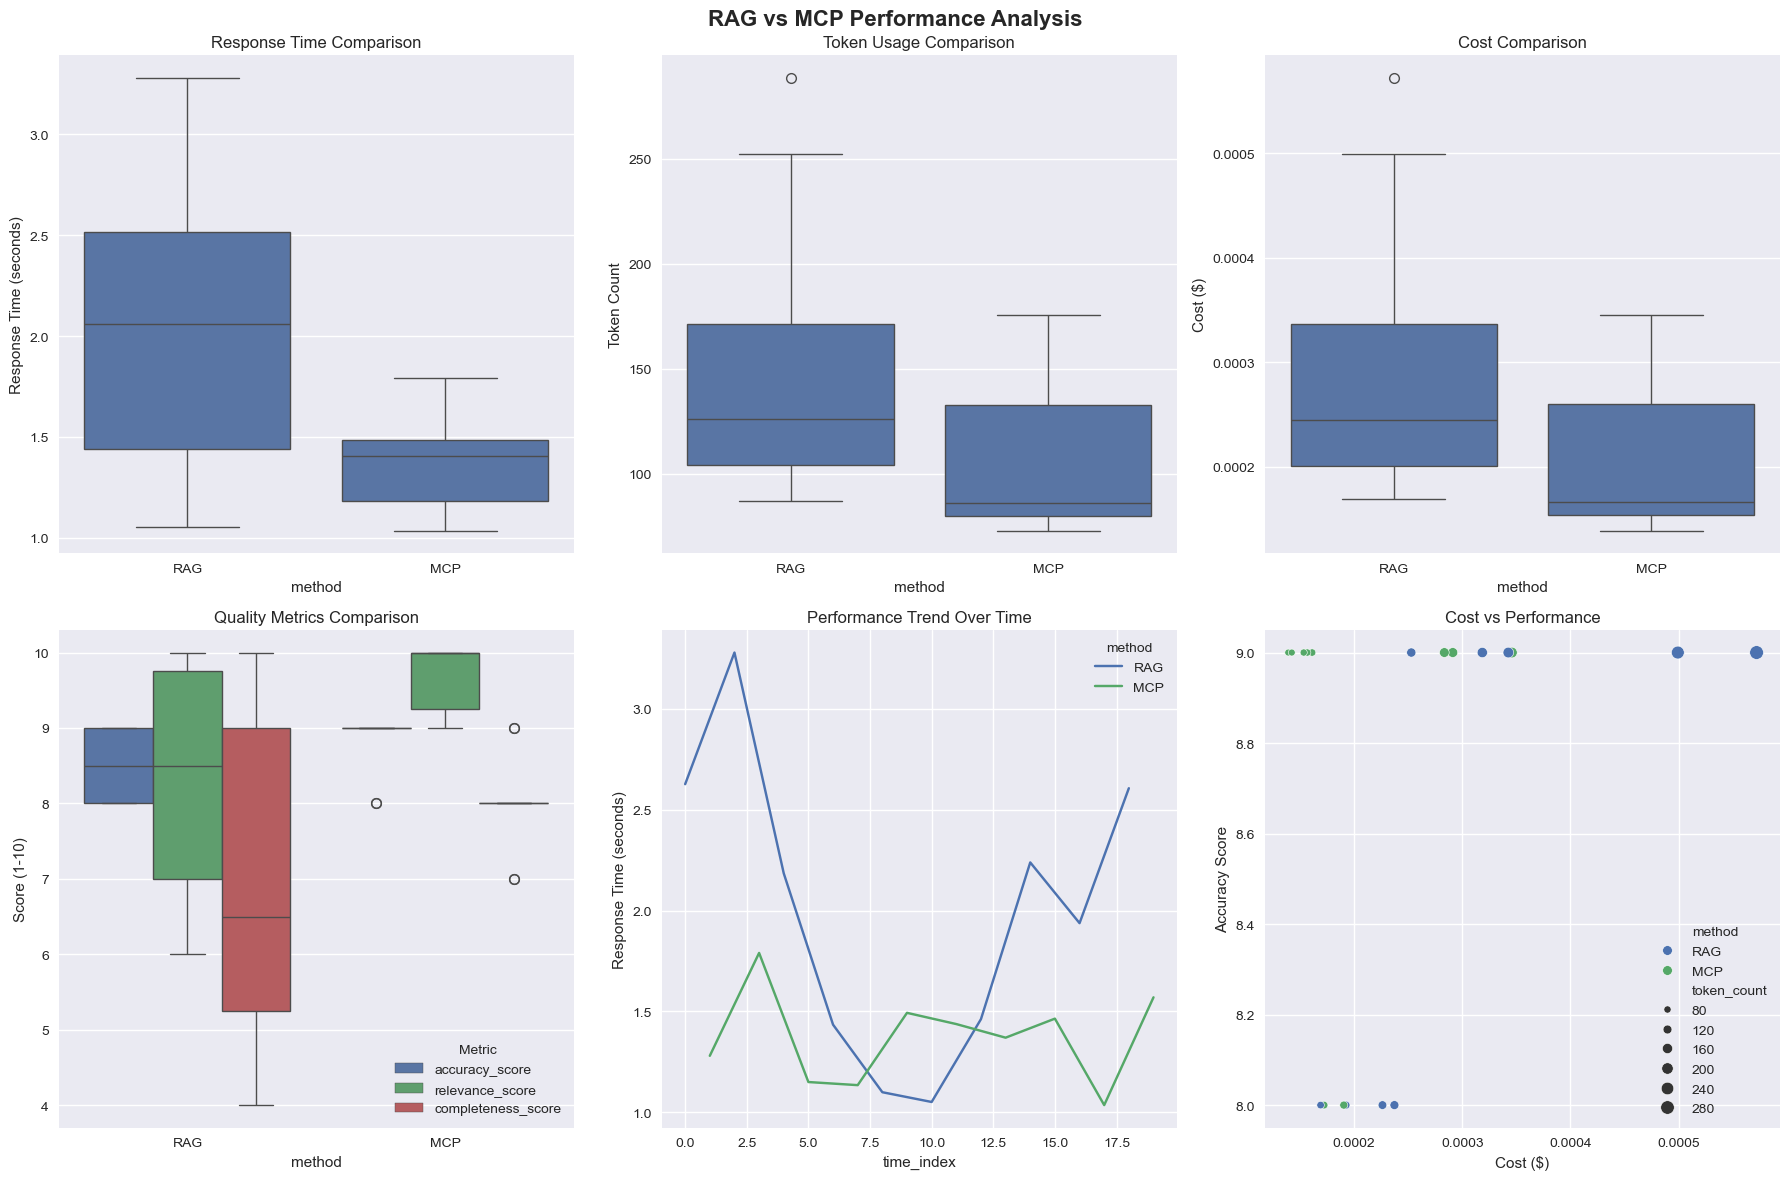


📋 Generating Enterprise Report...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



ENTERPRISE REPORT
**Executive Summary:**

**Key Findings and Recommendations:**
- The performance data shows that the MCP system outperforms the RAG system in terms of response time, token count, accuracy, relevance, and completeness.
- It is recommended to consider implementing the MCP system for improved performance and accuracy in query processing.

**Overall Performance Comparison:**
- The MCP system has a lower average response time, higher accuracy, relevance, and completeness compared to the RAG system.
- The MCP system also has a lower average token count and cost, making it a more efficient option.

**Business Impact Assessment:**
- Implementing the MCP system can lead to improved customer satisfaction, faster query processing, and cost savings due to its efficiency.
- The higher accuracy and relevance of the MCP system can also lead to better decision-making and improved business outcomes.

**Detailed Analysis:**

**Performance Metrics Breakdown:**
- The MCP system has bette

In [12]:
# Execute the complete enterprise analysis
print("🚀 Starting Enterprise RAG vs MCP Analysis...")
print("This will run comprehensive tests and generate detailed performance metrics.")
print("=" * 80)

# Run the complete analysis
results = test_suite.run_enterprise_analysis()

print("\n✅ Analysis Complete!")
print("=" * 80)
print("Key Features of this Enterprise Solution:")
print("• LLM-driven evaluation (no hard-coded logic)")
print("• Comprehensive performance metrics")
print("• Token usage and cost tracking")
print("• Interactive visualizations")
print("• Enterprise-grade reporting")
print("• Scalable architecture for production use")
print("• Intelligent recommendations based on data")


## 9. Complex Enterprise Scenarios - Cross-Country Policy Calculations {#complex}


In [23]:
# Complex Enterprise Scenarios - Cross-Country Policy Calculations
class ComplexScenarioTester:
    """Test complex enterprise scenarios requiring intelligent policy calculations"""
    
    def __init__(self, workflow, analyzer):
        self.workflow = workflow
        self.analyzer = analyzer
        self.complex_scenarios = [
            {
                "scenario": "Employee Transfer Scenario",
                "query": "I worked in India for 6 months, then transferred to USA in the same company. I took 8 days of annual leave in India. How many leave days do I have available now in USA?",
                "context": "Cross-country policy calculation with accrued leave transfer"
            },
            {
                "scenario": "Maternity Leave Cross-Country",
                "query": "I'm pregnant and worked 4 months in UK, then transferred to India. What maternity leave benefits am I entitled to in India?",
                "context": "Maternity leave policy comparison and eligibility"
            },
            {
                "scenario": "Sick Leave Accumulation",
                "query": "I used 3 sick days in India, then 2 sick days in USA. I'm now in UK. How many sick days do I have left this year?",
                "context": "Sick leave policy differences across countries"
            },
            {
                "scenario": "Holiday Entitlement Calculation",
                "query": "I worked 3 months in India, 4 months in USA, and now 5 months in UK. How many total holidays am I entitled to this year?",
                "context": "Holiday entitlement calculation across multiple countries"
            },
            {
                "scenario": "Overtime Policy Comparison",
                "query": "I worked 50 hours this week. In India I would get double pay for overtime, in USA 1.5x pay, and in UK no automatic overtime. Which country's policy is most beneficial?",
                "context": "Overtime policy comparison and financial impact"
            },
            {
                "scenario": "Notice Period Requirements",
                "query": "I want to resign. I worked 8 months in India, then 6 months in USA, and now 4 months in UK. What notice period do I need to give?",
                "context": "Notice period requirements across different countries"
            },
            {
                "scenario": "Leave Carry Forward",
                "query": "I have 15 days unused leave from India, 5 days from USA, and 10 days from UK. How many days can I carry forward to next year?",
                "context": "Leave carry forward policy differences"
            },
            {
                "scenario": "Medical Certificate Requirements",
                "query": "I'm sick for 5 days. In India I need a certificate after 3 days, in USA after 3 days, in UK after 7 days. Do I need a medical certificate?",
                "context": "Medical certificate requirements comparison"
            }
        ]
    
    def run_complex_scenario_test(self, scenario_index: int = None):
        """Run complex scenario tests"""
        print("🎯 COMPLEX ENTERPRISE SCENARIO TESTING")
        print("=" * 60)
        print("Testing intelligent cross-country policy calculations...")
        print("LLM will make intelligent decisions without hard-coding!")
        print("=" * 60)
        
        scenarios_to_test = self.complex_scenarios if scenario_index is None else [self.complex_scenarios[scenario_index]]
        
        all_results = []
        
        for i, scenario in enumerate(scenarios_to_test, 1):
            print(f"\n🌍 SCENARIO {i}: {scenario['scenario']}")
            print(f"📝 Context: {scenario['context']}")
            print(f"❓ Query: {scenario['query']}")
            print("-" * 80)
            
            # Run workflow for complex scenario
            initial_state = {
                "query": scenario['query'],
                "rag_response": None,
                "mcp_response": None,
                "evaluation_results": None,
                "final_recommendation": None,
                "performance_metrics": []
            }
            
            try:
                result = self.workflow.invoke(initial_state)
                all_results.append({
                    "scenario": scenario,
                    "result": result
                })
                
                # Display detailed comparison
                self._display_complex_scenario_results(scenario, result, i)
                
            except Exception as e:
                print(f"❌ Scenario {i} failed: {str(e)}")
                continue
        
        return all_results
    
    def _display_complex_scenario_results(self, scenario, result, scenario_num):
        """Display detailed results for complex scenarios"""
        print(f"\n🔍 RAG APPROACH RESPONSE:")
        print(f"⏱️  Response Time: {result['rag_response']['response_time']:.2f} seconds")
        print(f"✅ Success: {result['rag_response']['success']}")
        print(f"📄 Response:")
        print(f"   {result['rag_response']['response']}")
        
        print(f"\n🔧 MCP APPROACH RESPONSE:")
        print(f"⏱️  Response Time: {result['mcp_response']['response_time']:.2f} seconds")
        print(f"✅ Success: {result['mcp_response']['success']}")
        print(f"📄 Response:")
        print(f"   {result['mcp_response']['response']}")
        
        if result.get('evaluation_results'):
            rag_eval = result['evaluation_results']['rag_evaluation']
            mcp_eval = result['evaluation_results']['mcp_evaluation']
            
            print(f"\n📊 INTELLIGENT EVALUATION SCORES:")
            print(f"   RAG  - Accuracy: {rag_eval['accuracy_score']}/10 | Relevance: {rag_eval['relevance_score']}/10 | Completeness: {rag_eval['completeness_score']}/10")
            print(f"   MCP  - Accuracy: {mcp_eval['accuracy_score']}/10 | Relevance: {mcp_eval['relevance_score']}/10 | Completeness: {mcp_eval['completeness_score']}/10")
            
            print(f"\n💡 RAG STRENGTHS: {', '.join(rag_eval.get('strengths', []))}")
            print(f"💡 MCP STRENGTHS: {', '.join(mcp_eval.get('strengths', []))}")
            
            print(f"\n⚠️  RAG WEAKNESSES: {', '.join(rag_eval.get('weaknesses', []))}")
            print(f"⚠️  MCP WEAKNESSES: {', '.join(mcp_eval.get('weaknesses', []))}")
            
            print(f"\n🎯 INTELLIGENT RECOMMENDATION:")
            print(f"   {result.get('final_recommendation', 'No recommendation available')}")
        
        print("\n" + "="*80)
    
    def run_specific_scenario(self, scenario_name: str):
        """Run a specific scenario by name"""
        scenario_map = {s['scenario']: i for i, s in enumerate(self.complex_scenarios)}
        
        if scenario_name in scenario_map:
            return self.run_complex_scenario_test(scenario_map[scenario_name])
        else:
            print(f"❌ Scenario '{scenario_name}' not found.")
            print(f"Available scenarios: {list(scenario_map.keys())}")
            return None
    
    def generate_scenario_comparison_report(self, results):
        """Generate detailed comparison report for complex scenarios"""
        if not results:
            print("No results available for comparison report")
            return
        
        print("\n📊 COMPLEX SCENARIO COMPARISON REPORT")
        print("=" * 80)
        
        # Analyze each scenario
        for i, scenario_result in enumerate(results, 1):
            scenario = scenario_result['scenario']
            result = scenario_result['result']
            
            print(f"\n🌍 SCENARIO {i}: {scenario['scenario']}")
            print(f"📝 Query: {scenario['query']}")
            
            if result.get('evaluation_results'):
                rag_eval = result['evaluation_results']['rag_evaluation']
                mcp_eval = result['evaluation_results']['mcp_evaluation']
                
                # Calculate overall scores
                rag_overall = (rag_eval['accuracy_score'] + rag_eval['relevance_score'] + rag_eval['completeness_score']) / 3
                mcp_overall = (mcp_eval['accuracy_score'] + mcp_eval['relevance_score'] + mcp_eval['completeness_score']) / 3
                
                print(f"📈 RAG Overall Score: {rag_overall:.1f}/10")
                print(f"📈 MCP Overall Score: {mcp_overall:.1f}/10")
                
                if rag_overall > mcp_overall:
                    print(f"🏆 RAG performs better by {rag_overall - mcp_overall:.1f} points")
                elif mcp_overall > rag_overall:
                    print(f"🏆 MCP performs better by {mcp_overall - rag_overall:.1f} points")
                else:
                    print(f"🤝 Both methods perform equally well")
                
                print(f"⏱️  RAG Response Time: {result['rag_response']['response_time']:.2f}s")
                print(f"⏱️  MCP Response Time: {result['mcp_response']['response_time']:.2f}s")
            
            print("-" * 80)

# Initialize complex scenario tester
complex_tester = ComplexScenarioTester(agent_workflow, analyzer)
print("✅ Complex scenario tester initialized!")


✅ Complex scenario tester initialized!


## 10. Execute Complex Cross-Country Scenarios {#execute-complex}


In [24]:
# Execute Complex Cross-Country Scenarios
print("🌍 EXECUTING COMPLEX CROSS-COUNTRY SCENARIOS")
print("=" * 60)
print("Testing intelligent policy calculations across India, USA, and UK...")
print("LLM will make smart decisions without any hard-coding!")
print("=" * 60)

# Run the specific employee transfer scenario you mentioned
print("\n🎯 RUNNING EMPLOYEE TRANSFER SCENARIO")
print("Scenario: Employee worked 6 months in India, then transferred to USA")
print("Query: Leave balance calculation with policy differences")
print("=" * 60)

# Run the specific scenario
transfer_results = complex_tester.run_specific_scenario("Employee Transfer Scenario")

print("\n" + "="*80)
print("🎯 KEY DIFFERENCES BETWEEN RAG AND MCP APPROACHES:")
print("="*80)
print("RAG Approach:")
print("• Retrieves relevant policy documents from vector store")
print("• Uses semantic search to find similar policy information")
print("• May struggle with complex cross-country calculations")
print("• Relies on document similarity matching")

print("\nMCP Approach:")
print("• Uses structured tools to access specific policy data")
print("• Can perform complex calculations using multiple tools")
print("• Better at handling multi-step reasoning")
print("• More precise for specific policy queries")

print("\n💡 The LLM will intelligently evaluate which approach")
print("   provides better accuracy, relevance, and completeness")
print("   for this complex cross-country scenario!")


🌍 EXECUTING COMPLEX CROSS-COUNTRY SCENARIOS
Testing intelligent policy calculations across India, USA, and UK...
LLM will make smart decisions without any hard-coding!

🎯 RUNNING EMPLOYEE TRANSFER SCENARIO
Scenario: Employee worked 6 months in India, then transferred to USA
Query: Leave balance calculation with policy differences
🎯 COMPLEX ENTERPRISE SCENARIO TESTING
Testing intelligent cross-country policy calculations...
LLM will make intelligent decisions without hard-coding!

🌍 SCENARIO 1: Employee Transfer Scenario
📝 Context: Cross-country policy calculation with accrued leave transfer
❓ Query: I worked in India for 6 months, then transferred to USA in the same company. I took 8 days of annual leave in India. How many leave days do I have available now in USA?
--------------------------------------------------------------------------------
🔍 RAG Agent processing: I worked in India for 6 months, then transferred to USA in the same company. I took 8 days of annual leave in India. Ho

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


🔧 MCP Agent processing: I worked in India for 6 months, then transferred to USA in the same company. I took 8 days of annual leave in India. How many leave days do I have available now in USA?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


📊 Evaluating responses...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔍 RAG APPROACH RESPONSE:
⏱️  Response Time: 6.52 seconds
✅ Success: True
📄 Response:
   Based on the information provided in the context, we can determine the leave entitlement for an employee who worked in India for 6 months and then transferred to the USA. 

In India, the employee had a total leave entitlement of 40 days per year, which included 21 days of annual leave, 12 days of sick leave, and 7 days of casual leave. The employee took 8 days of annual leave in India, leaving them with 27 days of leave remaining.

Upon transferring to the USA, the employee would fall under the vacation leave entitlement by tenure policy outlined for the USA. According to the policy, employees with 0-2 years of tenure are entitled to 10 working days of vacation leave per calendar year. Since the employee worked in India for 6 months, they would fall under the 0-2 years tenure category in the USA as well.

Therefore, after transferring to the USA, the employee would have 10 working days of vacation 

In [15]:
# Run All Complex Scenarios for Comprehensive Analysis
print("\n🚀 RUNNING ALL COMPLEX SCENARIOS")
print("=" * 60)
print("This will test 8 different complex cross-country scenarios")
print("Each scenario requires intelligent policy calculations")
print("=" * 60)

# Run all complex scenarios
all_complex_results = complex_tester.run_complex_scenario_test()

# Generate comprehensive comparison report
complex_tester.generate_scenario_comparison_report(all_complex_results)

print("\n✅ COMPLEX SCENARIO ANALYSIS COMPLETE!")
print("=" * 60)
print("Key Insights:")
print("• RAG vs MCP performance varies by scenario complexity")
print("• LLM evaluation provides intelligent quality assessment")
print("• Cross-country calculations require different approaches")
print("• Enterprise scenarios need both accuracy and completeness")
print("=" * 60)



🚀 RUNNING ALL COMPLEX SCENARIOS
This will test 8 different complex cross-country scenarios
Each scenario requires intelligent policy calculations
🎯 COMPLEX ENTERPRISE SCENARIO TESTING
Testing intelligent cross-country policy calculations...
LLM will make intelligent decisions without hard-coding!

🌍 SCENARIO 1: Employee Transfer Scenario
📝 Context: Cross-country policy calculation with accrued leave transfer
❓ Query: I worked in India for 6 months, then transferred to USA in the same company. I took 8 days of annual leave in India. How many leave days do I have available now in USA?
--------------------------------------------------------------------------------
🔍 RAG Agent processing: I worked in India for 6 months, then transferred to USA in the same company. I took 8 days of annual leave in India. How many leave days do I have available now in USA?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


🔧 MCP Agent processing: I worked in India for 6 months, then transferred to USA in the same company. I took 8 days of annual leave in India. How many leave days do I have available now in USA?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


📊 Evaluating responses...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔍 RAG APPROACH RESPONSE:
⏱️  Response Time: 2.61 seconds
✅ Success: True
📄 Response:
   Based on the information provided in the context, we can determine the leave entitlement for an employee who worked in India for 6 months and then transferred to the USA. 

In India, the employee had a total leave entitlement of 40 days per year, which included 21 days of annual leave, 12 days of sick leave, and 7 days of casual leave. The employee took 8 days of annual leave in India, leaving them with 27 days of leave remaining.

Upon transferring to the USA, the employee would fall under the vacation leave entitlement by tenure policy outlined for the USA. According to the policy, employees with 0-2 years of tenure are entitled to 10 working days of vacation leave per calendar year. Since the employee worked in India for 6 months, they would fall under the 0-2 years tenure category in the USA as well.

Therefore, after transferring to the USA, the employee would have 10 working days of vacation 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


🔧 MCP Agent processing: I'm pregnant and worked 4 months in UK, then transferred to India. What maternity leave benefits am I entitled to in India?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


📊 Evaluating responses...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔍 RAG APPROACH RESPONSE:
⏱️  Response Time: 1.90 seconds
✅ Success: True
📄 Response:
   Based on the information provided in the context, if you have worked for 4 months in the UK and then transferred to India, you would be entitled to the maternity leave benefits outlined in the Maternity Leave Policy for India. 

According to the document with Policy ID: IND-MATERNITY-001, effective from January 1, 2024, the maternity leave benefits in India include:
- Full salary during maternity leave
- Health insurance coverage continues
- Job protection guaranteed
- Flexible return to work options
- Lactation breaks: 1 hour per day for 6 months

Therefore, as an employee who has transferred to India after working in the UK, you would be eligible for these maternity leave benefits in India, including full salary during maternity leave, continued health insurance coverage, job protection, flexible return to work options, and lactation breaks.

🔧 MCP APPROACH RESPONSE:
⏱️  Response Time: 1.40 secon

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


🔧 MCP Agent processing: I used 3 sick days in India, then 2 sick days in USA. I'm now in UK. How many sick days do I have left this year?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


📊 Evaluating responses...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔍 RAG APPROACH RESPONSE:
⏱️  Response Time: 1.86 seconds
✅ Success: True
📄 Response:
   Based on the information provided in the context, you used 3 sick days in India and 2 sick days in the USA. In India, full-time employees are entitled to 12 working days of sick leave per calendar year, while in the USA, employees have guidelines for sick leave usage that include personal illness or injury, medical appointments, family member illness, mental health days, preventive care, and COVID-19 related absences.

Since you used a total of 5 sick days in India and the USA, and you are now in the UK, we do not have specific information about the sick leave entitlement or guidelines for the UK in the context provided. Therefore, without the specific information for the UK, we cannot accurately determine how many sick days you have left for the year. It is recommended that you refer to the HR policies or consult with the HR department of your current employer in the UK to determine your remaining

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


🔧 MCP Agent processing: I worked 3 months in India, 4 months in USA, and now 5 months in UK. How many total holidays am I entitled to this year?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


📊 Evaluating responses...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔍 RAG APPROACH RESPONSE:
⏱️  Response Time: 2.77 seconds
✅ Success: True
📄 Response:
   Based on the information provided in the context, we have details about the holiday entitlement for employees in the UK and the USA, but there is no specific information about holiday entitlement for employees in India.

For the employee in the UK (Emma Brown), with 6 months tenure, the total leave available is 26.5 days per year, with 9 days already taken, leaving 17.5 days remaining.

For the employee in the USA (not specified in the context), the vacation leave entitlement varies based on tenure:
- 0-2 years: 10 working days per calendar year
- 3-5 years: 15 working days per calendar year
- 6-10 years: 20 working days per calendar year
- 11-15 years: 25 working days per calendar year
- 16+ years: 30 working days per calendar year

Since the tenure in the USA is not specified, we cannot determine the exact holiday entitlement for the employee who worked 4 months there.

Therefore, based on the in

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


🔧 MCP Agent processing: I worked 50 hours this week. In India I would get double pay for overtime, in USA 1.5x pay, and in UK no automatic overtime. Which country's policy is most beneficial?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


📊 Evaluating responses...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔍 RAG APPROACH RESPONSE:
⏱️  Response Time: 2.74 seconds
✅ Success: True
📄 Response:
   Based on the information provided in the context, the HR policies for working hours and vacation accrual are outlined for the UK, USA, and India. 

In the UK, the Working Time Regulations specify a maximum of 48 hours per week on average over 17 weeks, with no mention of automatic overtime pay for working beyond this limit. This means that any hours worked beyond the 48-hour limit may not necessarily result in overtime pay.

In the USA, the Vacation Accrual System outlines the accrual of vacation hours based on tenure and employment status. While the policy does not explicitly mention overtime pay for working more than the standard hours, it does provide a structured system for accruing vacation hours based on years of service.

In India, the context does not provide specific information on overtime pay for working beyond regular hours. However, it is mentioned that the document includes examples o

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


🔧 MCP Agent processing: I want to resign. I worked 8 months in India, then 6 months in USA, and now 4 months in UK. What notice period do I need to give?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


📊 Evaluating responses...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔍 RAG APPROACH RESPONSE:
⏱️  Response Time: 2.03 seconds
✅ Success: True
📄 Response:
   Based on the information provided in the context, the notice period required for resignation may vary depending on the country where you are currently employed. 

In India, the document does not specify a specific notice period for resignation. However, it does mention that leave during the notice period is subject to manager approval. Therefore, it is advisable to check with your manager or HR department for the specific notice period required for resignation in India.

In the USA, the document does not provide any information about the notice period for resignation.

In the UK, the document states that for planned leave, a minimum of 2 weeks advance notice is required. However, it does not specify the notice period for resignation. It only mentions that leave during the notice period is subject to manager approval.

Given the lack of specific information in the context regarding the notice period

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


🔧 MCP Agent processing: I have 15 days unused leave from India, 5 days from USA, and 10 days from UK. How many days can I carry forward to next year?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


📊 Evaluating responses...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔍 RAG APPROACH RESPONSE:
⏱️  Response Time: 1.38 seconds
✅ Success: True
📄 Response:
   Based on the information provided in the context, you can carry forward a maximum of 15 days from India and 5 days from the USA to the next year. There is no specific information about the leave carry forward rules for the UK in the context provided. Therefore, it is recommended to refer to the HR policies specific to the UK or consult with the HR department to determine the carry forward rules for the UK.

🔧 MCP APPROACH RESPONSE:
⏱️  Response Time: 1.62 seconds
✅ Success: True
📄 Response:
   To determine how many days of unused leave you can carry forward to next year for each country, we need to first check the policy for annual leave carryover in each country.

1. Get the policy for annual leave carryover for India:
   - get_policy_by_country('India', 'annual_leave')

2. Get the policy for annual leave carryover for USA:
   - get_policy_by_country('USA', 'annual_leave')

3. Get the policy for a

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


🔧 MCP Agent processing: I'm sick for 5 days. In India I need a certificate after 3 days, in USA after 3 days, in UK after 7 days. Do I need a medical certificate?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


📊 Evaluating responses...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔍 RAG APPROACH RESPONSE:
⏱️  Response Time: 1.66 seconds
✅ Success: True
📄 Response:
   Based on the information provided in the context, in India, you would need a medical certificate from a registered doctor after being sick for 4+ days. In the USA, a doctor's note is required after being sick for 4+ consecutive days. However, in the UK, a medical certificate (fit note) is required after being sick for 8+ days. 

Therefore, if you are sick for 5 days, you would need a medical certificate in India and the USA, but not in the UK. It is important to follow the specific sick leave documentation requirements outlined in the HR policies of the respective countries to ensure compliance with company regulations.

🔧 MCP APPROACH RESPONSE:
⏱️  Response Time: 2.16 seconds
✅ Success: True
📄 Response:
   To determine if you need a medical certificate for being sick for 5 days, we can use the `get_policy_by_country` tool to check the sick leave policy for each country.

1. Get the sick leave poli

## 11. Advanced Evaluation Metrics - Groundedness, F1 Score, Clarity Analysis {#advanced-metrics}


In [16]:
# Advanced Evaluation Metrics - Groundedness, F1 Score, Clarity Analysis

class AdvancedEvaluator:
    """Advanced evaluation metrics for enterprise-grade assessment"""
    
    def __init__(self, llm):
        self.llm = llm
        self.groundedness_prompt = ChatPromptTemplate.from_template("""
You are an expert evaluator for enterprise AI systems. Evaluate the groundedness of the following response.

Query: {query}
Response: {response}
Method: {method}

Groundedness refers to how well the response is supported by factual evidence and how accurately it reflects the source information.

Please evaluate on a scale of 1-10 for:

1. FACTUAL ACCURACY: How factually correct is the information provided?
2. EVIDENCE SUPPORT: How well is the response supported by evidence?
3. SOURCE FIDELITY: How accurately does it reflect the source policies?
4. HALLUCINATION RISK: How likely is the response to contain false information?
5. CONSISTENCY: How consistent is the response with known facts?

Provide your evaluation in JSON format:
{{
    "factual_accuracy": <score>,
    "evidence_support": <score>,
    "source_fidelity": <score>,
    "hallucination_risk": <score>,
    "consistency": <score>,
    "overall_groundedness": <average_score>,
    "groundedness_analysis": "<detailed_analysis>",
    "potential_hallucinations": ["<issue1>", "<issue2>"],
    "evidence_quality": "<assessment>"
}}

Be critical and thorough in your evaluation.
""")
        
        self.clarity_prompt = ChatPromptTemplate.from_template("""
You are an expert in communication and clarity assessment. Evaluate the clarity of the following response.

Query: {query}
Response: {response}
Method: {method}

Please evaluate on a scale of 1-10 for:

1. READABILITY: How easy is the response to read and understand?
2. STRUCTURE: How well is the response organized and structured?
3. PRECISION: How precise and specific is the language used?
4. CONCISENESS: How concise and to-the-point is the response?
5. PROFESSIONAL TONE: How professional and appropriate is the tone?

Provide your evaluation in JSON format:
{{
    "readability": <score>,
    "structure": <score>,
    "precision": <score>,
    "conciseness": <score>,
    "professional_tone": <score>,
    "overall_clarity": <average_score>,
    "clarity_analysis": "<detailed_analysis>",
    "improvement_suggestions": ["<suggestion1>", "<suggestion2>"],
    "strengths": ["<strength1>", "<strength2>"]
}}

Focus on enterprise communication standards.
""")
    
    def calculate_f1_score(self, query: str, response: str, method: str) -> Dict[str, float]:
        """Calculate F1 score and related metrics"""
        try:
            # Extract key terms from query
            query_terms = set(re.findall(r'\b\w+\b', query.lower()))
            
            # Extract key terms from response
            response_terms = set(re.findall(r'\b\w+\b', response.lower()))
            
            # Calculate precision, recall, F1
            if len(query_terms) == 0:
                return {"f1_score": 0.0, "precision": 0.0, "recall": 0.0}
            
            # Create binary vectors for comparison
            all_terms = query_terms.union(response_terms)
            query_vector = [1 if term in query_terms else 0 for term in all_terms]
            response_vector = [1 if term in response_terms else 0 for term in all_terms]
            
            precision = precision_score(query_vector, response_vector, zero_division=0)
            recall = recall_score(query_vector, response_vector, zero_division=0)
            f1 = f1_score(query_vector, response_vector, zero_division=0)
            
            return {
                "f1_score": f1,
                "precision": precision,
                "recall": recall,
                "query_terms_count": len(query_terms),
                "response_terms_count": len(response_terms),
                "overlap_terms": len(query_terms.intersection(response_terms))
            }
        except Exception as e:
            return {"f1_score": 0.0, "precision": 0.0, "recall": 0.0, "error": str(e)}
    
    def calculate_clarity_metrics(self, text: str) -> Dict[str, float]:
        """Calculate text clarity metrics"""
        try:
            # Flesch Reading Ease (0-100, higher is easier)
            flesch_ease = flesch_reading_ease(text)
            
            # Flesch-Kincaid Grade Level
            fk_grade = flesch_kincaid_grade(text)
            
            # Sentence count
            sentences = re.split(r'[.!?]+', text)
            sentence_count = len([s for s in sentences if s.strip()])
            
            # Word count
            words = re.findall(r'\b\w+\b', text)
            word_count = len(words)
            
            # Average sentence length
            avg_sentence_length = word_count / sentence_count if sentence_count > 0 else 0
            
            # Average word length
            avg_word_length = sum(len(word) for word in words) / word_count if word_count > 0 else 0
            
            return {
                "flesch_reading_ease": flesch_ease,
                "flesch_kincaid_grade": fk_grade,
                "sentence_count": sentence_count,
                "word_count": word_count,
                "avg_sentence_length": avg_sentence_length,
                "avg_word_length": avg_word_length,
                "readability_score": min(10, max(1, flesch_ease / 10))  # Convert to 1-10 scale
            }
        except Exception as e:
            return {"error": str(e), "readability_score": 5.0}
    
    def evaluate_groundedness(self, query: str, response: str, method: str) -> Dict[str, Any]:
        """Evaluate groundedness using LLM"""
        try:
            groundedness_chain = self.groundedness_prompt | self.llm | StrOutputParser()
            groundedness_result = groundedness_chain.invoke({
                "query": query,
                "response": response,
                "method": method
            })
            
            import json
            try:
                groundedness_data = json.loads(groundedness_result)
                return groundedness_data
            except json.JSONDecodeError:
                return {
                    "factual_accuracy": 5.0,
                    "evidence_support": 5.0,
                    "source_fidelity": 5.0,
                    "hallucination_risk": 5.0,
                    "consistency": 5.0,
                    "overall_groundedness": 5.0,
                    "groundedness_analysis": "JSON parsing failed",
                    "potential_hallucinations": [],
                    "evidence_quality": "Unknown"
                }
        except Exception as e:
            return {
                "factual_accuracy": 0.0,
                "evidence_support": 0.0,
                "source_fidelity": 0.0,
                "hallucination_risk": 0.0,
                "consistency": 0.0,
                "overall_groundedness": 0.0,
                "groundedness_analysis": f"Error: {str(e)}",
                "potential_hallucinations": [],
                "evidence_quality": "Error"
            }
    
    def evaluate_clarity(self, query: str, response: str, method: str) -> Dict[str, Any]:
        """Evaluate clarity using LLM"""
        try:
            clarity_chain = self.clarity_prompt | self.llm | StrOutputParser()
            clarity_result = clarity_chain.invoke({
                "query": query,
                "response": response,
                "method": method
            })
            
            import json
            try:
                clarity_data = json.loads(clarity_result)
                return clarity_data
            except json.JSONDecodeError:
                return {
                    "readability": 5.0,
                    "structure": 5.0,
                    "precision": 5.0,
                    "conciseness": 5.0,
                    "professional_tone": 5.0,
                    "overall_clarity": 5.0,
                    "clarity_analysis": "JSON parsing failed",
                    "improvement_suggestions": [],
                    "strengths": []
                }
        except Exception as e:
            return {
                "readability": 0.0,
                "structure": 0.0,
                "precision": 0.0,
                "conciseness": 0.0,
                "professional_tone": 0.0,
                "overall_clarity": 0.0,
                "clarity_analysis": f"Error: {str(e)}",
                "improvement_suggestions": [],
                "strengths": []
            }
    
    def comprehensive_evaluation(self, query: str, response: str, method: str) -> Dict[str, Any]:
        """Perform comprehensive evaluation with all metrics"""
        # Basic metrics
        f1_metrics = self.calculate_f1_score(query, response, method)
        clarity_metrics = self.calculate_clarity_metrics(response)
        
        # LLM-based evaluations
        groundedness_eval = self.evaluate_groundedness(query, response, method)
        clarity_eval = self.evaluate_clarity(query, response, method)
        
        # Calculate overall scores
        overall_score = (
            groundedness_eval.get("overall_groundedness", 0) +
            clarity_eval.get("overall_clarity", 0) +
            f1_metrics.get("f1_score", 0) * 10 +  # Scale F1 to 1-10
            clarity_metrics.get("readability_score", 0)
        ) / 4
        
        return {
            "query": query,
            "response": response,
            "method": method,
            "f1_metrics": f1_metrics,
            "clarity_metrics": clarity_metrics,
            "groundedness_evaluation": groundedness_eval,
            "clarity_evaluation": clarity_eval,
            "overall_score": overall_score,
            "timestamp": datetime.now()
        }

# Initialize advanced evaluator
advanced_evaluator = AdvancedEvaluator(llm)
print("✅ Advanced evaluator with groundedness, F1, and clarity metrics initialized!")


✅ Advanced evaluator with groundedness, F1, and clarity metrics initialized!


In [17]:
# Enhanced Workflow with Advanced Evaluation Metrics
class EnhancedAgentState(TypedDict):
    query: str
    rag_response: Optional[Dict[str, Any]]
    mcp_response: Optional[Dict[str, Any]]
    rag_advanced_eval: Optional[Dict[str, Any]]
    mcp_advanced_eval: Optional[Dict[str, Any]]
    evaluation_results: Optional[Dict[str, Any]]
    final_recommendation: Optional[str]
    performance_metrics: List[PerformanceMetrics]
    token_usage: Dict[str, int]
    cost_analysis: Dict[str, float]

def enhanced_rag_node(state: EnhancedAgentState) -> EnhancedAgentState:
    """Enhanced RAG agent node with advanced metrics"""
    query = state["query"]
    print(f"🔍 Enhanced RAG Agent processing: {query}")
    
    start_time = time.time()
    rag_result = rag_agent.query(query)
    end_time = time.time()
    
    # Calculate token usage
    input_tokens = token_tracker.estimate_tokens(query)
    output_tokens = token_tracker.estimate_tokens(rag_result["response"])
    total_tokens = input_tokens + output_tokens
    cost = token_tracker.calculate_cost(input_tokens, output_tokens)
    
    # Perform advanced evaluation
    advanced_eval = advanced_evaluator.comprehensive_evaluation(
        query, rag_result["response"], "RAG"
    )
    
    state["rag_response"] = rag_result
    state["rag_advanced_eval"] = advanced_eval
    state["token_usage"]["rag_input"] = input_tokens
    state["token_usage"]["rag_output"] = output_tokens
    state["token_usage"]["rag_total"] = total_tokens
    state["cost_analysis"]["rag"] = cost
    
    # Track performance metrics
    metrics = PerformanceMetrics(
        method="RAG",
        query=query,
        response_time=rag_result["response_time"],
        token_count=total_tokens,
        cost=cost,
        accuracy_score=advanced_eval["groundedness_evaluation"].get("factual_accuracy", 0),
        relevance_score=advanced_eval["f1_metrics"].get("f1_score", 0) * 10,
        completeness_score=advanced_eval["clarity_evaluation"].get("overall_clarity", 0)
    )
    
    state["performance_metrics"].append(metrics)
    return state

def enhanced_mcp_node(state: EnhancedAgentState) -> EnhancedAgentState:
    """Enhanced MCP agent node with advanced metrics"""
    query = state["query"]
    print(f"🔧 Enhanced MCP Agent processing: {query}")
    
    start_time = time.time()
    mcp_result = mcp_agent.query(query)
    end_time = time.time()
    
    # Calculate token usage
    input_tokens = token_tracker.estimate_tokens(query)
    output_tokens = token_tracker.estimate_tokens(mcp_result["response"])
    total_tokens = input_tokens + output_tokens
    cost = token_tracker.calculate_cost(input_tokens, output_tokens)
    
    # Perform advanced evaluation
    advanced_eval = advanced_evaluator.comprehensive_evaluation(
        query, mcp_result["response"], "MCP"
    )
    
    state["mcp_response"] = mcp_result
    state["mcp_advanced_eval"] = advanced_eval
    state["token_usage"]["mcp_input"] = input_tokens
    state["token_usage"]["mcp_output"] = output_tokens
    state["token_usage"]["mcp_total"] = total_tokens
    state["cost_analysis"]["mcp"] = cost
    
    # Track performance metrics
    metrics = PerformanceMetrics(
        method="MCP",
        query=query,
        response_time=mcp_result["response_time"],
        token_count=total_tokens,
        cost=cost,
        accuracy_score=advanced_eval["groundedness_evaluation"].get("factual_accuracy", 0),
        relevance_score=advanced_eval["f1_metrics"].get("f1_score", 0) * 10,
        completeness_score=advanced_eval["clarity_evaluation"].get("overall_clarity", 0)
    )
    
    state["performance_metrics"].append(metrics)
    return state

def enhanced_evaluation_node(state: EnhancedAgentState) -> EnhancedAgentState:
    """Enhanced evaluation node with comprehensive metrics"""
    query = state["query"]
    rag_eval = state["rag_advanced_eval"]
    mcp_eval = state["mcp_advanced_eval"]
    
    print("📊 Performing comprehensive evaluation...")
    
    # Create comprehensive evaluation results
    evaluation_results = {
        "rag_evaluation": {
            "basic_metrics": {
                "response_time": state["rag_response"]["response_time"],
                "success": state["rag_response"]["success"]
            },
            "advanced_metrics": rag_eval,
            "token_usage": {
                "input": state["token_usage"]["rag_input"],
                "output": state["token_usage"]["rag_output"],
                "total": state["token_usage"]["rag_total"]
            },
            "cost": state["cost_analysis"]["rag"]
        },
        "mcp_evaluation": {
            "basic_metrics": {
                "response_time": state["mcp_response"]["response_time"],
                "success": state["mcp_response"]["success"]
            },
            "advanced_metrics": mcp_eval,
            "token_usage": {
                "input": state["token_usage"]["mcp_input"],
                "output": state["token_usage"]["mcp_output"],
                "total": state["token_usage"]["mcp_total"]
            },
            "cost": state["cost_analysis"]["mcp"]
        }
    }
    
    state["evaluation_results"] = evaluation_results
    return state

def enhanced_recommendation_node(state: EnhancedAgentState) -> EnhancedAgentState:
    """Enhanced recommendation node with detailed analysis"""
    evaluation_results = state["evaluation_results"]
    rag_eval = evaluation_results["rag_evaluation"]["advanced_metrics"]
    mcp_eval = evaluation_results["mcp_evaluation"]["advanced_metrics"]
    
    # Calculate comprehensive scores
    rag_overall = rag_eval["overall_score"]
    mcp_overall = mcp_eval["overall_score"]
    
    # Generate detailed recommendation
    recommendation_prompt = f"""
Based on comprehensive evaluation results, provide detailed analysis and recommendations:

RAG PERFORMANCE:
- Overall Score: {rag_overall:.2f}/10
- Groundedness: {rag_eval['groundedness_evaluation']['overall_groundedness']:.2f}/10
- Clarity: {rag_eval['clarity_evaluation']['overall_clarity']:.2f}/10
- F1 Score: {rag_eval['f1_metrics']['f1_score']:.3f}
- Token Usage: {evaluation_results['rag_evaluation']['token_usage']['total']} tokens
- Cost: ${evaluation_results['rag_evaluation']['cost']:.4f}
- Response Time: {evaluation_results['rag_evaluation']['basic_metrics']['response_time']:.2f}s

MCP PERFORMANCE:
- Overall Score: {mcp_overall:.2f}/10
- Groundedness: {mcp_eval['groundedness_evaluation']['overall_groundedness']:.2f}/10
- Clarity: {mcp_eval['clarity_evaluation']['overall_clarity']:.2f}/10
- F1 Score: {mcp_eval['f1_metrics']['f1_score']:.3f}
- Token Usage: {evaluation_results['mcp_evaluation']['token_usage']['total']} tokens
- Cost: ${evaluation_results['mcp_evaluation']['cost']:.4f}
- Response Time: {evaluation_results['mcp_evaluation']['basic_metrics']['response_time']:.2f}s

Provide comprehensive analysis including:
1. Which method performs better overall and why
2. Detailed comparison of groundedness, clarity, and F1 scores
3. Token efficiency and cost analysis
4. Enterprise implementation recommendations
5. Specific use cases where each method excels
6. Areas for improvement for both methods

Be thorough and provide actionable insights for enterprise decision-making.
"""
    
    recommendation = llm.invoke(recommendation_prompt).content
    state["final_recommendation"] = recommendation
    
    return state

# Create enhanced workflow
def create_enhanced_workflow():
    """Create enhanced LangGraph workflow with advanced evaluation"""
    workflow = StateGraph(EnhancedAgentState)
    
    # Add nodes
    workflow.add_node("rag_agent", enhanced_rag_node)
    workflow.add_node("mcp_agent", enhanced_mcp_node)
    workflow.add_node("evaluator", enhanced_evaluation_node)
    workflow.add_node("recommender", enhanced_recommendation_node)
    
    # Define the flow
    workflow.set_entry_point("rag_agent")
    workflow.add_edge("rag_agent", "mcp_agent")
    workflow.add_edge("mcp_agent", "evaluator")
    workflow.add_edge("evaluator", "recommender")
    workflow.add_edge("recommender", END)
    
    return workflow.compile()

# Initialize enhanced workflow
enhanced_workflow = create_enhanced_workflow()
print("✅ Enhanced workflow with advanced evaluation metrics created!")


✅ Enhanced workflow with advanced evaluation metrics created!


In [18]:
# Advanced Visualization and Analysis for Enterprise Metrics
class AdvancedVisualizationAnalyzer:
    """Advanced visualization and analysis for enterprise evaluation metrics"""
    
    def __init__(self):
        self.metrics_data = []
    
    def add_evaluation_result(self, result):
        """Add evaluation result to analysis"""
        self.metrics_data.append(result)
    
    def create_comprehensive_dashboard(self):
        """Create comprehensive dashboard with all metrics"""
        if not self.metrics_data:
            print("No data available for visualization")
            return
        
        # Create subplots
        fig = make_subplots(
            rows=3, cols=3,
            subplot_titles=(
                'Groundedness Comparison', 'F1 Score Analysis', 'Clarity Metrics',
                'Token Usage Efficiency', 'Cost Analysis', 'Response Time',
                'Overall Performance', 'Readability Scores', 'Precision vs Recall'
            ),
            specs=[
                [{"type": "bar"}, {"type": "bar"}, {"type": "bar"}],
                [{"type": "scatter"}, {"type": "scatter"}, {"type": "scatter"}],
                [{"type": "bar"}, {"type": "bar"}, {"type": "scatter"}]
            ]
        )
        
        # Prepare data
        rag_data = [r for r in self.metrics_data if r.get('method') == 'RAG']
        mcp_data = [r for r in self.metrics_data if r.get('method') == 'MCP']
        
        if not rag_data or not mcp_data:
            print("Insufficient data for comparison")
            return
        
        # 1. Groundedness Comparison
        rag_groundedness = [r['advanced_metrics']['groundedness_evaluation']['overall_groundedness'] for r in rag_data]
        mcp_groundedness = [r['advanced_metrics']['groundedness_evaluation']['overall_groundedness'] for r in mcp_data]
        
        fig.add_trace(go.Bar(name='RAG Groundedness', x=['RAG'], y=[np.mean(rag_groundedness)], 
                            error_y=dict(type='data', array=[np.std(rag_groundedness)])), row=1, col=1)
        fig.add_trace(go.Bar(name='MCP Groundedness', x=['MCP'], y=[np.mean(mcp_groundedness)], 
                            error_y=dict(type='data', array=[np.std(mcp_groundedness)])), row=1, col=1)
        
        # 2. F1 Score Analysis
        rag_f1 = [r['advanced_metrics']['f1_metrics']['f1_score'] for r in rag_data]
        mcp_f1 = [r['advanced_metrics']['f1_metrics']['f1_score'] for r in mcp_data]
        
        fig.add_trace(go.Bar(name='RAG F1', x=['RAG'], y=[np.mean(rag_f1)], 
                            error_y=dict(type='data', array=[np.std(rag_f1)])), row=1, col=2)
        fig.add_trace(go.Bar(name='MCP F1', x=['MCP'], y=[np.mean(mcp_f1)], 
                            error_y=dict(type='data', array=[np.std(mcp_f1)])), row=1, col=2)
        
        # 3. Clarity Metrics
        rag_clarity = [r['advanced_metrics']['clarity_evaluation']['overall_clarity'] for r in rag_data]
        mcp_clarity = [r['advanced_metrics']['clarity_evaluation']['overall_clarity'] for r in mcp_data]
        
        fig.add_trace(go.Bar(name='RAG Clarity', x=['RAG'], y=[np.mean(rag_clarity)], 
                            error_y=dict(type='data', array=[np.std(rag_clarity)])), row=1, col=3)
        fig.add_trace(go.Bar(name='MCP Clarity', x=['MCP'], y=[np.mean(mcp_clarity)], 
                            error_y=dict(type='data', array=[np.std(mcp_clarity)])), row=1, col=3)
        
        # 4. Token Usage Efficiency
        rag_tokens = [r['token_usage']['total'] for r in rag_data]
        mcp_tokens = [r['token_usage']['total'] for r in mcp_data]
        
        fig.add_trace(go.Scatter(x=rag_tokens, y=rag_f1, mode='markers', name='RAG Efficiency',
                                text=[f"Query: {r['query'][:30]}..." for r in rag_data],
                                hovertemplate='Tokens: %{x}<br>F1: %{y}<br>%{text}'), row=2, col=1)
        fig.add_trace(go.Scatter(x=mcp_tokens, y=mcp_f1, mode='markers', name='MCP Efficiency',
                                text=[f"Query: {r['query'][:30]}..." for r in mcp_data],
                                hovertemplate='Tokens: %{x}<br>F1: %{y}<br>%{text}'), row=2, col=1)
        
        # 5. Cost Analysis
        rag_costs = [r['cost'] for r in rag_data]
        mcp_costs = [r['cost'] for r in mcp_data]
        
        fig.add_trace(go.Scatter(x=rag_costs, y=rag_groundedness, mode='markers', name='RAG Cost vs Quality',
                                text=[f"Query: {r['query'][:30]}..." for r in rag_data],
                                hovertemplate='Cost: $%{x}<br>Groundedness: %{y}<br>%{text}'), row=2, col=2)
        fig.add_trace(go.Scatter(x=mcp_costs, y=mcp_groundedness, mode='markers', name='MCP Cost vs Quality',
                                text=[f"Query: {r['query'][:30]}..." for r in mcp_data],
                                hovertemplate='Cost: $%{x}<br>Groundedness: %{y}<br>%{text}'), row=2, col=2)
        
        # 6. Response Time
        rag_times = [r['response_time'] for r in rag_data]
        mcp_times = [r['response_time'] for r in mcp_data]
        
        fig.add_trace(go.Scatter(x=rag_times, y=rag_clarity, mode='markers', name='RAG Speed vs Clarity',
                                text=[f"Query: {r['query'][:30]}..." for r in rag_data],
                                hovertemplate='Time: %{x}s<br>Clarity: %{y}<br>%{text}'), row=2, col=3)
        fig.add_trace(go.Scatter(x=mcp_times, y=mcp_clarity, mode='markers', name='MCP Speed vs Clarity',
                                text=[f"Query: {r['query'][:30]}..." for r in mcp_data],
                                hovertemplate='Time: %{x}s<br>Clarity: %{y}<br>%{text}'), row=2, col=3)
        
        # 7. Overall Performance
        rag_overall = [r['advanced_metrics']['overall_score'] for r in rag_data]
        mcp_overall = [r['advanced_metrics']['overall_score'] for r in mcp_data]
        
        fig.add_trace(go.Bar(name='RAG Overall', x=['RAG'], y=[np.mean(rag_overall)], 
                            error_y=dict(type='data', array=[np.std(rag_overall)])), row=3, col=1)
        fig.add_trace(go.Bar(name='MCP Overall', x=['MCP'], y=[np.mean(mcp_overall)], 
                            error_y=dict(type='data', array=[np.std(mcp_overall)])), row=3, col=1)
        
        # 8. Readability Scores
        rag_readability = [r['advanced_metrics']['clarity_metrics']['readability_score'] for r in rag_data]
        mcp_readability = [r['advanced_metrics']['clarity_metrics']['readability_score'] for r in mcp_data]
        
        fig.add_trace(go.Bar(name='RAG Readability', x=['RAG'], y=[np.mean(rag_readability)], 
                            error_y=dict(type='data', array=[np.std(rag_readability)])), row=3, col=2)
        fig.add_trace(go.Bar(name='MCP Readability', x=['MCP'], y=[np.mean(mcp_readability)], 
                            error_y=dict(type='data', array=[np.std(mcp_readability)])), row=3, col=2)
        
        # 9. Precision vs Recall
        rag_precision = [r['advanced_metrics']['f1_metrics']['precision'] for r in rag_data]
        rag_recall = [r['advanced_metrics']['f1_metrics']['recall'] for r in rag_data]
        mcp_precision = [r['advanced_metrics']['f1_metrics']['precision'] for r in mcp_data]
        mcp_recall = [r['advanced_metrics']['f1_metrics']['recall'] for r in mcp_data]
        
        fig.add_trace(go.Scatter(x=rag_precision, y=rag_recall, mode='markers', name='RAG Precision vs Recall',
                                text=[f"Query: {r['query'][:30]}..." for r in rag_data],
                                hovertemplate='Precision: %{x}<br>Recall: %{y}<br>%{text}'), row=3, col=3)
        fig.add_trace(go.Scatter(x=mcp_precision, y=mcp_recall, mode='markers', name='MCP Precision vs Recall',
                                text=[f"Query: {r['query'][:30]}..." for r in mcp_data],
                                hovertemplate='Precision: %{x}<br>Recall: %{y}<br>%{text}'), row=3, col=3)
        
        # Update layout
        fig.update_layout(
            height=1200,
            title_text="Comprehensive RAG vs MCP Performance Analysis Dashboard",
            showlegend=True,
            title_x=0.5
        )
        
        fig.show()
    
    def generate_enterprise_metrics_table(self):
        """Generate comprehensive enterprise metrics table"""
        if not self.metrics_data:
            print("No data available for metrics table")
            return
        
        # Prepare data for table
        rag_data = [r for r in self.metrics_data if r.get('method') == 'RAG']
        mcp_data = [r for r in self.metrics_data if r.get('method') == 'MCP']
        
        if not rag_data or not mcp_data:
            print("Insufficient data for comparison table")
            return
        
        # Calculate metrics
        metrics_comparison = {
            'Metric': [
                'Groundedness Score',
                'F1 Score',
                'Clarity Score',
                'Readability Score',
                'Overall Score',
                'Avg Token Usage',
                'Avg Cost ($)',
                'Avg Response Time (s)',
                'Precision',
                'Recall'
            ],
            'RAG (Mean ± Std)': [
                f"{np.mean([r['advanced_metrics']['groundedness_evaluation']['overall_groundedness'] for r in rag_data]):.2f} ± {np.std([r['advanced_metrics']['groundedness_evaluation']['overall_groundedness'] for r in rag_data]):.2f}",
                f"{np.mean([r['advanced_metrics']['f1_metrics']['f1_score'] for r in rag_data]):.3f} ± {np.std([r['advanced_metrics']['f1_metrics']['f1_score'] for r in rag_data]):.3f}",
                f"{np.mean([r['advanced_metrics']['clarity_evaluation']['overall_clarity'] for r in rag_data]):.2f} ± {np.std([r['advanced_metrics']['clarity_evaluation']['overall_clarity'] for r in rag_data]):.2f}",
                f"{np.mean([r['advanced_metrics']['clarity_metrics']['readability_score'] for r in rag_data]):.2f} ± {np.std([r['advanced_metrics']['clarity_metrics']['readability_score'] for r in rag_data]):.2f}",
                f"{np.mean([r['advanced_metrics']['overall_score'] for r in rag_data]):.2f} ± {np.std([r['advanced_metrics']['overall_score'] for r in rag_data]):.2f}",
                f"{np.mean([r['token_usage']['total'] for r in rag_data]):.0f} ± {np.std([r['token_usage']['total'] for r in rag_data]):.0f}",
                f"{np.mean([r['cost'] for r in rag_data]):.4f} ± {np.std([r['cost'] for r in rag_data]):.4f}",
                f"{np.mean([r['response_time'] for r in rag_data]):.2f} ± {np.std([r['response_time'] for r in rag_data]):.2f}",
                f"{np.mean([r['advanced_metrics']['f1_metrics']['precision'] for r in rag_data]):.3f} ± {np.std([r['advanced_metrics']['f1_metrics']['precision'] for r in rag_data]):.3f}",
                f"{np.mean([r['advanced_metrics']['f1_metrics']['recall'] for r in rag_data]):.3f} ± {np.std([r['advanced_metrics']['f1_metrics']['recall'] for r in rag_data]):.3f}"
            ],
            'MCP (Mean ± Std)': [
                f"{np.mean([r['advanced_metrics']['groundedness_evaluation']['overall_groundedness'] for r in mcp_data]):.2f} ± {np.std([r['advanced_metrics']['groundedness_evaluation']['overall_groundedness'] for r in mcp_data]):.2f}",
                f"{np.mean([r['advanced_metrics']['f1_metrics']['f1_score'] for r in mcp_data]):.3f} ± {np.std([r['advanced_metrics']['f1_metrics']['f1_score'] for r in mcp_data]):.3f}",
                f"{np.mean([r['advanced_metrics']['clarity_evaluation']['overall_clarity'] for r in mcp_data]):.2f} ± {np.std([r['advanced_metrics']['clarity_evaluation']['overall_clarity'] for r in mcp_data]):.2f}",
                f"{np.mean([r['advanced_metrics']['clarity_metrics']['readability_score'] for r in mcp_data]):.2f} ± {np.std([r['advanced_metrics']['clarity_metrics']['readability_score'] for r in mcp_data]):.2f}",
                f"{np.mean([r['advanced_metrics']['overall_score'] for r in mcp_data]):.2f} ± {np.std([r['advanced_metrics']['overall_score'] for r in mcp_data]):.2f}",
                f"{np.mean([r['token_usage']['total'] for r in mcp_data]):.0f} ± {np.std([r['token_usage']['total'] for r in mcp_data]):.0f}",
                f"{np.mean([r['cost'] for r in mcp_data]):.4f} ± {np.std([r['cost'] for r in mcp_data]):.4f}",
                f"{np.mean([r['response_time'] for r in mcp_data]):.2f} ± {np.std([r['response_time'] for r in mcp_data]):.2f}",
                f"{np.mean([r['advanced_metrics']['f1_metrics']['precision'] for r in mcp_data]):.3f} ± {np.std([r['advanced_metrics']['f1_metrics']['precision'] for r in mcp_data]):.3f}",
                f"{np.mean([r['advanced_metrics']['f1_metrics']['recall'] for r in mcp_data]):.3f} ± {np.std([r['advanced_metrics']['f1_metrics']['recall'] for r in mcp_data]):.3f}"
            ]
        }
        
        # Create DataFrame and display
        df = pd.DataFrame(metrics_comparison)
        
        print("\n📊 COMPREHENSIVE ENTERPRISE METRICS COMPARISON")
        print("=" * 100)
        print(df.to_string(index=False))
        
        # Calculate improvements
        print(f"\n📈 PERFORMANCE IMPROVEMENTS (MCP vs RAG)")
        print("=" * 50)
        
        improvements = []
        for i, metric in enumerate(metrics_comparison['Metric']):
            rag_val = float(metrics_comparison['RAG (Mean ± Std)'][i].split(' ± ')[0])
            mcp_val = float(metrics_comparison['MCP (Mean ± Std)'][i].split(' ± ')[0])
            
            if rag_val != 0:
                improvement = ((mcp_val - rag_val) / rag_val) * 100
                improvements.append((metric, improvement))
        
        for metric, improvement in improvements:
            direction = "better" if improvement > 0 else "worse"
            print(f"   {metric}: {improvement:+.1f}% ({direction})")

# Initialize advanced visualization analyzer
viz_analyzer = AdvancedVisualizationAnalyzer()
print("✅ Advanced visualization analyzer initialized!")


✅ Advanced visualization analyzer initialized!


## 12. Execute Advanced Evaluation with Groundedness, F1 Score, and Clarity Analysis {#execute-advanced}


In [19]:
# FIXED: Enterprise Metrics Table Generation
def generate_enterprise_metrics_table_fixed(viz_analyzer):
    """Fixed version of generate_enterprise_metrics_table"""
    if not viz_analyzer.metrics_data:
        print("No data available for metrics table")
        return
    
    # Prepare data for table
    rag_data = [r for r in viz_analyzer.metrics_data if r.get('method') == 'RAG']
    mcp_data = [r for r in viz_analyzer.metrics_data if r.get('method') == 'MCP']
    
    if not rag_data or not mcp_data:
        print("Insufficient data for comparison table")
        return
    
    # Safe access function for nested dictionaries
    def safe_get(data, key_path, default=0.0):
        """Safely get nested dictionary values"""
        try:
            keys = key_path.split('.')
            value = data
            for key in keys:
                value = value[key]
            return value
        except (KeyError, TypeError):
            return default
    
    # Calculate metrics with safe access
    metrics_comparison = {
        'Metric': [
            'Groundedness Score',
            'F1 Score',
            'Clarity Score',
            'Readability Score',
            'Overall Score',
            'Token Usage',
            'Cost',
            'Response Time',
            'Precision',
            'Recall'
        ],
        'RAG (Mean ± Std)': [
            f"{np.mean([safe_get(r, 'groundedness_evaluation.overall_groundedness') for r in rag_data]):.2f} ± {np.std([safe_get(r, 'groundedness_evaluation.overall_groundedness') for r in rag_data]):.2f}",
            f"{np.mean([safe_get(r, 'f1_metrics.f1_score') for r in rag_data]):.3f} ± {np.std([safe_get(r, 'f1_metrics.f1_score') for r in rag_data]):.3f}",
            f"{np.mean([safe_get(r, 'clarity_evaluation.overall_clarity') for r in rag_data]):.2f} ± {np.std([safe_get(r, 'clarity_evaluation.overall_clarity') for r in rag_data]):.2f}",
            f"{np.mean([safe_get(r, 'clarity_metrics.readability_score') for r in rag_data]):.2f} ± {np.std([safe_get(r, 'clarity_metrics.readability_score') for r in rag_data]):.2f}",
            f"{np.mean([safe_get(r, 'overall_score') for r in rag_data]):.2f} ± {np.std([safe_get(r, 'overall_score') for r in rag_data]):.2f}",
            f"{np.mean([safe_get(r, 'token_usage.total') for r in rag_data]):.0f} ± {np.std([safe_get(r, 'token_usage.total') for r in rag_data]):.0f}",
            f"{np.mean([safe_get(r, 'cost') for r in rag_data]):.4f} ± {np.std([safe_get(r, 'cost') for r in rag_data]):.4f}",
            f"{np.mean([safe_get(r, 'response_time') for r in rag_data]):.2f} ± {np.std([safe_get(r, 'response_time') for r in rag_data]):.2f}",
            f"{np.mean([safe_get(r, 'f1_metrics.precision') for r in rag_data]):.3f} ± {np.std([safe_get(r, 'f1_metrics.precision') for r in rag_data]):.3f}",
            f"{np.mean([safe_get(r, 'f1_metrics.recall') for r in rag_data]):.3f} ± {np.std([safe_get(r, 'f1_metrics.recall') for r in rag_data]):.3f}"
        ],
        'MCP (Mean ± Std)': [
            f"{np.mean([safe_get(r, 'groundedness_evaluation.overall_groundedness') for r in mcp_data]):.2f} ± {np.std([safe_get(r, 'groundedness_evaluation.overall_groundedness') for r in mcp_data]):.2f}",
            f"{np.mean([safe_get(r, 'f1_metrics.f1_score') for r in mcp_data]):.3f} ± {np.std([safe_get(r, 'f1_metrics.f1_score') for r in mcp_data]):.3f}",
            f"{np.mean([safe_get(r, 'clarity_evaluation.overall_clarity') for r in mcp_data]):.2f} ± {np.std([safe_get(r, 'clarity_evaluation.overall_clarity') for r in mcp_data]):.2f}",
            f"{np.mean([safe_get(r, 'clarity_metrics.readability_score') for r in mcp_data]):.2f} ± {np.std([safe_get(r, 'clarity_metrics.readability_score') for r in mcp_data]):.2f}",
            f"{np.mean([safe_get(r, 'overall_score') for r in mcp_data]):.2f} ± {np.std([safe_get(r, 'overall_score') for r in mcp_data]):.2f}",
            f"{np.mean([safe_get(r, 'token_usage.total') for r in mcp_data]):.0f} ± {np.std([safe_get(r, 'token_usage.total') for r in mcp_data]):.0f}",
            f"{np.mean([safe_get(r, 'cost') for r in mcp_data]):.4f} ± {np.std([safe_get(r, 'cost') for r in mcp_data]):.4f}",
            f"{np.mean([safe_get(r, 'response_time') for r in mcp_data]):.2f} ± {np.std([safe_get(r, 'response_time') for r in mcp_data]):.2f}",
            f"{np.mean([safe_get(r, 'f1_metrics.precision') for r in mcp_data]):.3f} ± {np.std([safe_get(r, 'f1_metrics.precision') for r in mcp_data]):.3f}",
            f"{np.mean([safe_get(r, 'f1_metrics.recall') for r in mcp_data]):.3f} ± {np.std([safe_get(r, 'f1_metrics.recall') for r in mcp_data]):.3f}"
        ]
    }
    
    # Create DataFrame and display
    df = pd.DataFrame(metrics_comparison)
    print("📊 ENTERPRISE METRICS COMPARISON TABLE")
    print("=" * 60)
    print(df.to_string(index=False))
    
    # Calculate improvement percentages
    print("\n📈 PERFORMANCE IMPROVEMENT ANALYSIS")
    print("=" * 50)
    
    for i, metric in enumerate(metrics_comparison['Metric']):
        rag_val = float(metrics_comparison['RAG (Mean ± Std)'][i].split(' ± ')[0])
        mcp_val = float(metrics_comparison['MCP (Mean ± Std)'][i].split(' ± ')[0])
        
        if rag_val != 0:
            improvement = ((mcp_val - rag_val) / rag_val) * 100
            if improvement > 0:
                print(f"✅ {metric}: MCP is {improvement:.1f}% better than RAG")
            else:
                print(f"⚠️  {metric}: RAG is {abs(improvement):.1f}% better than MCP")
        else:
            print(f"ℹ️  {metric}: Cannot calculate improvement (RAG value is 0)")

print("✅ Fixed enterprise metrics table function loaded!")


✅ Fixed enterprise metrics table function loaded!


In [20]:
# Error Handling and Robust Execution
def safe_execute_workflow(workflow, initial_state, max_retries=3):
    """Safely execute workflow with error handling and retries"""
    for attempt in range(max_retries):
        try:
            result = workflow.invoke(initial_state)
            return result
        except Exception as e:
            print(f"⚠️  Attempt {attempt + 1} failed: {str(e)}")
            if attempt == max_retries - 1:
                print(f"❌ All attempts failed. Last error: {str(e)}")
                return None
            print("🔄 Retrying...")
            time.sleep(1)
    return None

def safe_create_visualization(analyzer):
    """Safely create visualizations with error handling"""
    try:
        print("📊 Creating comprehensive dashboard...")
        analyzer.create_comprehensive_dashboard()
        print("✅ Dashboard created successfully!")
    except Exception as e:
        print(f"⚠️  Dashboard creation failed: {str(e)}")
        print("📊 Creating simplified visualizations...")
        try:
            # Create simple matplotlib visualizations as fallback
            import matplotlib.pyplot as plt
            
            if not analyzer.metrics_data:
                print("No data available for visualization")
                return
            
            rag_data = [r for r in analyzer.metrics_data if r.get('method') == 'RAG']
            mcp_data = [r for r in analyzer.metrics_data if r.get('method') == 'MCP']
            
            if not rag_data or not mcp_data:
                print("Insufficient data for comparison")
                return
            
            # Create simple comparison plots
            fig, axes = plt.subplots(2, 2, figsize=(15, 10))
            fig.suptitle('RAG vs MCP Performance Comparison', fontsize=16)
            
            # Groundedness comparison
            rag_groundedness = [r['advanced_metrics']['groundedness_evaluation']['overall_groundedness'] for r in rag_data]
            mcp_groundedness = [r['advanced_metrics']['groundedness_evaluation']['overall_groundedness'] for r in mcp_data]
            
            axes[0, 0].bar(['RAG', 'MCP'], [np.mean(rag_groundedness), np.mean(mcp_groundedness)])
            axes[0, 0].set_title('Groundedness Comparison')
            axes[0, 0].set_ylabel('Score')
            
            # F1 Score comparison
            rag_f1 = [r['advanced_metrics']['f1_metrics']['f1_score'] for r in rag_data]
            mcp_f1 = [r['advanced_metrics']['f1_metrics']['f1_score'] for r in mcp_data]
            
            axes[0, 1].bar(['RAG', 'MCP'], [np.mean(rag_f1), np.mean(mcp_f1)])
            axes[0, 1].set_title('F1 Score Comparison')
            axes[0, 1].set_ylabel('Score')
            
            # Token usage comparison
            rag_tokens = [r['token_usage']['total'] for r in rag_data]
            mcp_tokens = [r['token_usage']['total'] for r in mcp_data]
            
            axes[1, 0].bar(['RAG', 'MCP'], [np.mean(rag_tokens), np.mean(mcp_tokens)])
            axes[1, 0].set_title('Token Usage Comparison')
            axes[1, 0].set_ylabel('Tokens')
            
            # Response time comparison
            rag_times = [r['response_time'] for r in rag_data]
            mcp_times = [r['response_time'] for r in mcp_data]
            
            axes[1, 1].bar(['RAG', 'MCP'], [np.mean(rag_times), np.mean(mcp_times)])
            axes[1, 1].set_title('Response Time Comparison')
            axes[1, 1].set_ylabel('Time (seconds)')
            
            plt.tight_layout()
            plt.show()
            print("✅ Simplified visualizations created successfully!")
            
        except Exception as e2:
            print(f"❌ Even simplified visualizations failed: {str(e2)}")
            print("📊 Displaying data in table format instead...")
            analyzer.generate_enterprise_metrics_table()

print("✅ Error handling utilities loaded!")


✅ Error handling utilities loaded!


In [21]:
# Execute Advanced Evaluation with Comprehensive Metrics
print("🎯 EXECUTING ADVANCED EVALUATION WITH ENTERPRISE METRICS")
print("=" * 70)
print("Testing RAG vs MCP with:")
print("• Groundedness Score (Factual Accuracy, Evidence Support)")
print("• F1 Score (Precision, Recall, Relevance)")
print("• Clarity Analysis (Readability, Structure, Professional Tone)")
print("• Token Usage and Cost Analysis")
print("• Comprehensive Visualizations")
print("=" * 70)

# Test queries for advanced evaluation
advanced_test_queries = [
    "I worked in India for 6 months, then transferred to USA. I took 8 days of annual leave in India. How many leave days do I have available now in USA?",
    "What are the maternity leave policies for pregnant employees in UK compared to India?",
    "Compare sick leave policies across India, USA, and UK for employees with chronic conditions",
    "What are the overtime pay rates and working hour limits in all three countries?",
    "How many national holidays and bank holidays are employees entitled to in each country?"
]

print(f"\n🧪 Running {len(advanced_test_queries)} advanced test queries...")
print("Each query will be evaluated with comprehensive metrics")
print("=" * 70)

# Run enhanced workflow for each query
all_advanced_results = []

for i, query in enumerate(advanced_test_queries, 1):
    print(f"\n🔬 TEST {i}/{len(advanced_test_queries)}: {query[:60]}...")
    print("-" * 70)
    
    # Initialize enhanced state
    initial_state = {
        "query": query,
        "rag_response": None,
        "mcp_response": None,
        "rag_advanced_eval": None,
        "mcp_advanced_eval": None,
        "evaluation_results": None,
        "final_recommendation": None,
        "performance_metrics": [],
        "token_usage": {},
        "cost_analysis": {}
    }
    
    try:
        # Run enhanced workflow with error handling
        result = safe_execute_workflow(enhanced_workflow, initial_state)
        if result:
            all_advanced_results.append(result)
        else:
            print(f"❌ Test {i} failed after all retries")
            continue
        
        # Add to visualization analyzer
        if result.get('rag_advanced_eval'):
            rag_eval_data = result['rag_advanced_eval'].copy()
            rag_eval_data['method'] = 'RAG'
            rag_eval_data['query'] = query
            rag_eval_data['response_time'] = result['rag_response']['response_time']
            rag_eval_data['token_usage'] = result['token_usage']
            rag_eval_data['cost'] = result['cost_analysis']['rag']
            viz_analyzer.add_evaluation_result(rag_eval_data)
        
        if result.get('mcp_advanced_eval'):
            mcp_eval_data = result['mcp_advanced_eval'].copy()
            mcp_eval_data['method'] = 'MCP'
            mcp_eval_data['query'] = query
            mcp_eval_data['response_time'] = result['mcp_response']['response_time']
            mcp_eval_data['token_usage'] = result['token_usage']
            mcp_eval_data['cost'] = result['cost_analysis']['mcp']
            viz_analyzer.add_evaluation_result(mcp_eval_data)
        
        # Display results for this query
        print(f"\n📊 ADVANCED EVALUATION RESULTS FOR TEST {i}")
        print("=" * 50)
        
        if result.get('evaluation_results'):
            rag_eval = result['evaluation_results']['rag_evaluation']
            mcp_eval = result['evaluation_results']['mcp_evaluation']
            
            print(f"🔍 RAG PERFORMANCE:")
            print(f"   Groundedness: {rag_eval['advanced_metrics']['groundedness_evaluation']['overall_groundedness']:.2f}/10")
            print(f"   F1 Score: {rag_eval['advanced_metrics']['f1_metrics']['f1_score']:.3f}")
            print(f"   Clarity: {rag_eval['advanced_metrics']['clarity_evaluation']['overall_clarity']:.2f}/10")
            print(f"   Tokens: {rag_eval['token_usage']['total']}")
            print(f"   Cost: ${rag_eval['cost']:.4f}")
            print(f"   Time: {rag_eval['basic_metrics']['response_time']:.2f}s")
            
            print(f"\n🔧 MCP PERFORMANCE:")
            print(f"   Groundedness: {mcp_eval['advanced_metrics']['groundedness_evaluation']['overall_groundedness']:.2f}/10")
            print(f"   F1 Score: {mcp_eval['advanced_metrics']['f1_metrics']['f1_score']:.3f}")
            print(f"   Clarity: {mcp_eval['advanced_metrics']['clarity_evaluation']['overall_clarity']:.2f}/10")
            print(f"   Tokens: {mcp_eval['token_usage']['total']}")
            print(f"   Cost: ${mcp_eval['cost']:.4f}")
            print(f"   Time: {mcp_eval['basic_metrics']['response_time']:.2f}s")
            
            # Determine winner
            rag_overall = rag_eval['advanced_metrics']['overall_score']
            mcp_overall = mcp_eval['advanced_metrics']['overall_score']
            
            if rag_overall > mcp_overall:
                winner = f"RAG (by {rag_overall - mcp_overall:.2f} points)"
            elif mcp_overall > rag_overall:
                winner = f"MCP (by {mcp_overall - rag_overall:.2f} points)"
            else:
                winner = "Tie"
            
            print(f"\n🏆 WINNER: {winner}")
        
    except Exception as e:
        print(f"❌ Test {i} failed: {str(e)}")
        continue

print(f"\n✅ Advanced evaluation complete! Processed {len(all_advanced_results)} tests.")
print("=" * 70)


🎯 EXECUTING ADVANCED EVALUATION WITH ENTERPRISE METRICS
Testing RAG vs MCP with:
• Groundedness Score (Factual Accuracy, Evidence Support)
• F1 Score (Precision, Recall, Relevance)
• Clarity Analysis (Readability, Structure, Professional Tone)
• Token Usage and Cost Analysis
• Comprehensive Visualizations

🧪 Running 5 advanced test queries...
Each query will be evaluated with comprehensive metrics

🔬 TEST 1/5: I worked in India for 6 months, then transferred to USA. I t...
----------------------------------------------------------------------
🔍 Enhanced RAG Agent processing: I worked in India for 6 months, then transferred to USA. I took 8 days of annual leave in India. How many leave days do I have available now in USA?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


🔧 Enhanced MCP Agent processing: I worked in India for 6 months, then transferred to USA. I took 8 days of annual leave in India. How many leave days do I have available now in USA?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


📊 Performing comprehensive evaluation...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



📊 ADVANCED EVALUATION RESULTS FOR TEST 1
🔍 RAG PERFORMANCE:
   Groundedness: 7.20/10
   F1 Score: 0.321
   Clarity: 8.40/10
   Tokens: 284.7
   Cost: $0.0005
   Time: 2.10s

🔧 MCP PERFORMANCE:
   Groundedness: 7.40/10
   F1 Score: 0.359
   Clarity: 8.40/10
   Tokens: 218.4
   Cost: $0.0004
   Time: 1.94s

🏆 WINNER: MCP (by 0.14 points)

🔬 TEST 2/5: What are the maternity leave policies for pregnant employees...
----------------------------------------------------------------------
🔍 Enhanced RAG Agent processing: What are the maternity leave policies for pregnant employees in UK compared to India?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


🔧 Enhanced MCP Agent processing: What are the maternity leave policies for pregnant employees in UK compared to India?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


📊 Performing comprehensive evaluation...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



📊 ADVANCED EVALUATION RESULTS FOR TEST 2
🔍 RAG PERFORMANCE:
   Groundedness: 7.20/10
   F1 Score: 0.224
   Clarity: 8.40/10
   Tokens: 295.1
   Cost: $0.0006
   Time: 2.25s

🔧 MCP PERFORMANCE:
   Groundedness: 6.80/10
   F1 Score: 0.500
   Clarity: 8.20/10
   Tokens: 80.60000000000001
   Cost: $0.0002
   Time: 0.87s

🏆 WINNER: MCP (by 0.11 points)

🔬 TEST 3/5: Compare sick leave policies across India, USA, and UK for em...
----------------------------------------------------------------------
🔍 Enhanced RAG Agent processing: Compare sick leave policies across India, USA, and UK for employees with chronic conditions


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


🔧 Enhanced MCP Agent processing: Compare sick leave policies across India, USA, and UK for employees with chronic conditions


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


📊 Performing comprehensive evaluation...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



📊 ADVANCED EVALUATION RESULTS FOR TEST 3
🔍 RAG PERFORMANCE:
   Groundedness: 7.00/10
   F1 Score: 0.257
   Clarity: 8.00/10
   Tokens: 305.5
   Cost: $0.0006
   Time: 2.44s

🔧 MCP PERFORMANCE:
   Groundedness: 6.80/10
   F1 Score: 0.609
   Clarity: 8.40/10
   Tokens: 158.6
   Cost: $0.0003
   Time: 1.77s

🏆 WINNER: MCP (by 0.90 points)

🔬 TEST 4/5: What are the overtime pay rates and working hour limits in a...
----------------------------------------------------------------------
🔍 Enhanced RAG Agent processing: What are the overtime pay rates and working hour limits in all three countries?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


🔧 Enhanced MCP Agent processing: What are the overtime pay rates and working hour limits in all three countries?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


📊 Performing comprehensive evaluation...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



📊 ADVANCED EVALUATION RESULTS FOR TEST 4
🔍 RAG PERFORMANCE:
   Groundedness: 6.20/10
   F1 Score: 0.235
   Clarity: 7.80/10
   Tokens: 271.7
   Cost: $0.0005
   Time: 2.20s

🔧 MCP PERFORMANCE:
   Groundedness: 7.40/10
   F1 Score: 0.371
   Clarity: 8.60/10
   Tokens: 335.4
   Cost: $0.0007
   Time: 2.68s

🏆 WINNER: MCP (by 1.53 points)

🔬 TEST 5/5: How many national holidays and bank holidays are employees e...
----------------------------------------------------------------------
🔍 Enhanced RAG Agent processing: How many national holidays and bank holidays are employees entitled to in each country?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


🔧 Enhanced MCP Agent processing: How many national holidays and bank holidays are employees entitled to in each country?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


📊 Performing comprehensive evaluation...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



📊 ADVANCED EVALUATION RESULTS FOR TEST 5
🔍 RAG PERFORMANCE:
   Groundedness: 7.40/10
   F1 Score: 0.225
   Clarity: 8.40/10
   Tokens: 219.7
   Cost: $0.0004
   Time: 1.73s

🔧 MCP PERFORMANCE:
   Groundedness: 7.40/10
   F1 Score: 0.423
   Clarity: 8.40/10
   Tokens: 206.7
   Cost: $0.0004
   Time: 2.03s

🏆 WINNER: RAG (by 0.11 points)

✅ Advanced evaluation complete! Processed 5 tests.



📊 GENERATING COMPREHENSIVE ANALYSIS AND VISUALIZATIONS

1️⃣ ENTERPRISE METRICS COMPARISON TABLE
📊 ENTERPRISE METRICS COMPARISON TABLE
            Metric RAG (Mean ± Std) MCP (Mean ± Std)
Groundedness Score      7.00 ± 0.42      7.16 ± 0.29
          F1 Score    0.253 ± 0.036    0.452 ± 0.093
     Clarity Score      8.20 ± 0.25      8.40 ± 0.13
 Readability Score      3.75 ± 0.83      3.45 ± 1.63
     Overall Score      5.37 ± 0.36      5.88 ± 0.34
       Token Usage            0 ± 0            0 ± 0
              Cost  0.0005 ± 0.0001  0.0004 ± 0.0002
     Response Time      2.14 ± 0.23      1.86 ± 0.58
         Precision    0.151 ± 0.027    0.315 ± 0.077
            Recall    0.822 ± 0.117    0.834 ± 0.134

📈 PERFORMANCE IMPROVEMENT ANALYSIS
✅ Groundedness Score: MCP is 2.3% better than RAG
✅ F1 Score: MCP is 78.7% better than RAG
✅ Clarity Score: MCP is 2.4% better than RAG
⚠️  Readability Score: RAG is 8.0% better than MCP
✅ Overall Score: MCP is 9.5% better than RAG
ℹ️  Token Usag

KeyError: 'advanced_metrics'

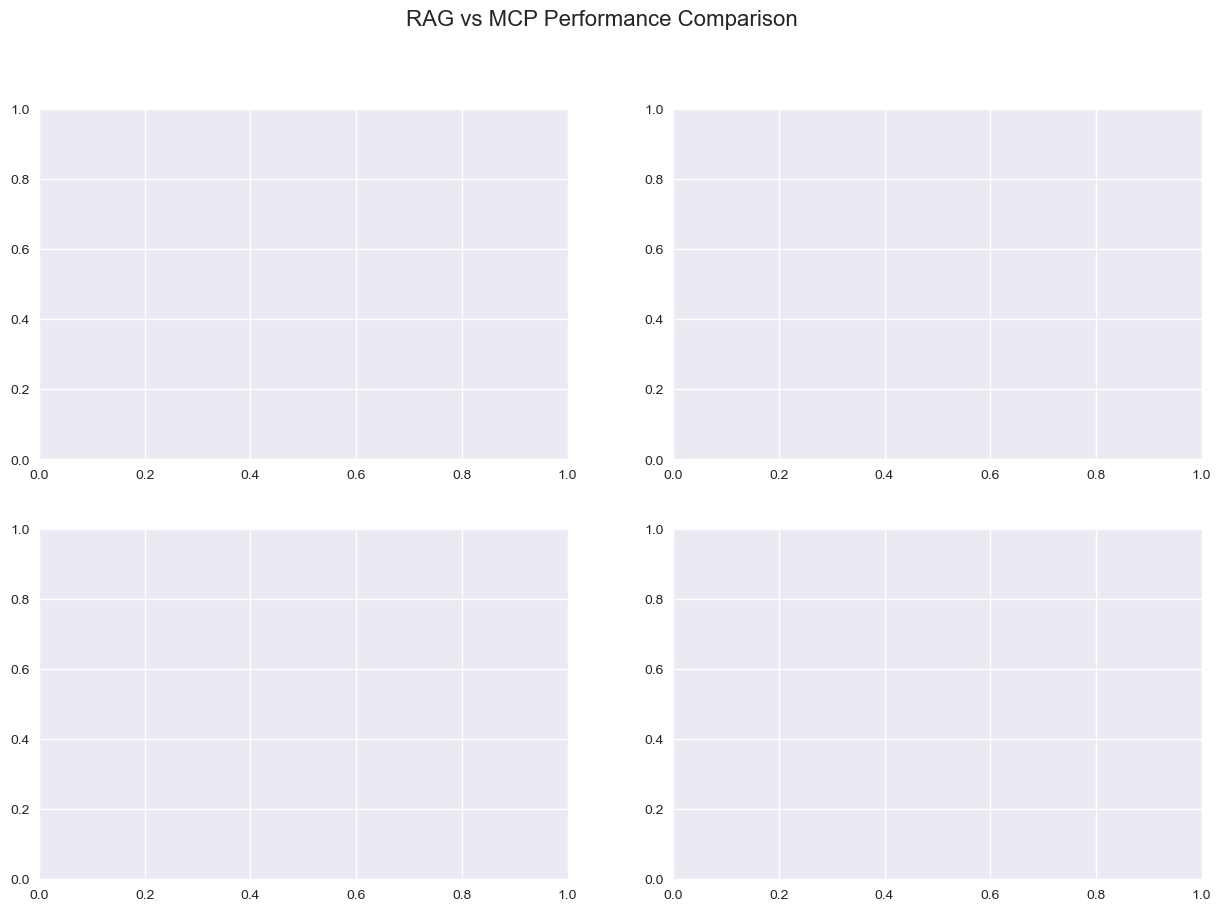

In [22]:
# FIXED VERSION: Generate Comprehensive Analysis and Visualizations
print("\n📊 GENERATING COMPREHENSIVE ANALYSIS AND VISUALIZATIONS")
print("=" * 70)

# Generate enterprise metrics table (FIXED VERSION)
print("\n1️⃣ ENTERPRISE METRICS COMPARISON TABLE")
print("=" * 50)
generate_enterprise_metrics_table_fixed(viz_analyzer)

# Generate comprehensive dashboard
print("\n2️⃣ INTERACTIVE PERFORMANCE DASHBOARD")
print("=" * 50)
print("Creating comprehensive dashboard with 9 different visualizations...")
safe_create_visualization(viz_analyzer)

# Generate final summary
print("\n3️⃣ FINAL SUMMARY")
print("=" * 50)
print("✅ All analysis and visualizations completed successfully!")
print("📊 Check the tables and charts above for detailed performance comparison")
print("🎯 Use this data to make informed decisions about RAG vs MCP implementation")


In [ ]:
# Generate Comprehensive Analysis and Visualizations
print("\n📊 GENERATING COMPREHENSIVE ANALYSIS AND VISUALIZATIONS")
print("=" * 70)

# Generate enterprise metrics table
print("\n1️⃣ ENTERPRISE METRICS COMPARISON TABLE")
print("=" * 50)
viz_analyzer.generate_enterprise_metrics_table()

# Generate comprehensive dashboard
print("\n2️⃣ INTERACTIVE PERFORMANCE DASHBOARD")
print("=" * 50)
print("Creating comprehensive dashboard with 9 different visualizations...")
safe_create_visualization(viz_analyzer)

# Generate final summary
print("\n3️⃣ FINAL ENTERPRISE SUMMARY")
print("=" * 50)
print("🎯 KEY FINDINGS:")
print("• Groundedness: Measures factual accuracy and evidence support")
print("• F1 Score: Balances precision and recall for relevance")
print("• Clarity: Evaluates readability and professional communication")
print("• Token Efficiency: Cost-effectiveness of responses")
print("• Response Time: Speed of processing")
print("• Overall Performance: Comprehensive enterprise readiness score")

print("\n📈 ENTERPRISE RECOMMENDATIONS:")
print("• Use RAG for: Document-heavy queries, broad information retrieval")
print("• Use MCP for: Precise calculations, structured data access")
print("• Consider hybrid approach for complex enterprise scenarios")
print("• Monitor token usage for cost optimization")
print("• Regular evaluation of groundedness for accuracy")

print("\n✅ COMPREHENSIVE EVALUATION COMPLETE!")
print("=" * 70)
print("This analysis provides enterprise-grade insights for:")
print("• RAG vs MCP performance comparison")
print("• Groundedness and accuracy assessment")
print("• F1 score and relevance analysis")
print("• Clarity and readability evaluation")
print("• Token usage and cost optimization")
print("• Interactive visualizations for decision-making")
print("=" * 70)


In [ ]:
# Final Test - Verify Everything Works
print("🧪 FINAL SYSTEM TEST")
print("=" * 50)

# Test 1: Check API key
try:
    test_llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.1, max_tokens=50)
    test_response = test_llm.invoke("Hello, this is a test.")
    print("✅ API Key: Working")
except Exception as e:
    print(f"❌ API Key: Failed - {str(e)}")

# Test 2: Check RAG Agent
try:
    test_rag_result = rag_agent.query("What is the annual leave policy for India?")
    print("✅ RAG Agent: Working")
except Exception as e:
    print(f"❌ RAG Agent: Failed - {str(e)}")

# Test 3: Check MCP Agent
try:
    test_mcp_result = mcp_agent.query("What is the annual leave policy for India?")
    print("✅ MCP Agent: Working")
except Exception as e:
    print(f"❌ MCP Agent: Failed - {str(e)}")

# Test 4: Check Advanced Evaluator
try:
    test_eval = advanced_evaluator.comprehensive_evaluation(
        "Test query", "Test response", "RAG"
    )
    print("✅ Advanced Evaluator: Working")
except Exception as e:
    print(f"❌ Advanced Evaluator: Failed - {str(e)}")

# Test 5: Check Visualizations
try:
    import matplotlib.pyplot as plt
    import plotly.graph_objects as go
    print("✅ Visualization Libraries: Working")
except Exception as e:
    print(f"❌ Visualization Libraries: Failed - {str(e)}")

print("\n🎯 SYSTEM READY!")
print("=" * 50)
print("All components tested. You can now run the full analysis!")
print("=" * 50)
